In [3]:
import os
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import glob  
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pyranges as pr
from kipoiseq import Interval
import pyfaidx
import kipoiseq
from collections import Counter
import gseapy as gp
import seaborn as sns
from memelite import tomtom, fimo
from memelite.io import read_meme
from memelite.utils import one_hot_encode
import gseapy as gp
import matplotlib as mpl # 
from matplotlib_venn import venn2, venn3

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# %matplotlib inline

In [3]:
# gwas_regenie = pd.read_csv('../FOODIE_20250407/20250821_GWAS_common_results/MCH.site_all_site_all_var_result.2025-08-06.txt', sep='\t')

In [2]:
# 0.009718

In [99]:
gwas_regenie[gwas_regenie['ID'] == 'DRAGEN:chr6:41957260:C:T']

,CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,p_regenie,mask,MAC
938,6,41957260,DRAGEN:chr6:41957260:C:T,C,T,0.009718,1,469409,ADD,0.366342,0.009578,1462.99,319.365,NaN,4.315169e-320,6_30815518_45913049,9123.0


In [3]:
motifs = read_meme("../FOODIE_20250407/JASPAR_MEME/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt")
len(motifs.keys())

879

In [3]:
K562_foodie = pr.read_bed('../FOODIE_20250407/FOODIE_merged_footprints/K562.merged.hg38.bed')
K562_foodie.extend(50).merge().length

16056899

In [4]:
K562_foodie = pr.read_bed('../FOODIE_20250407/FOODIE_merged_footprints/K562.merged.hg38.bed').df
GM12878_foodie = pr.read_bed('../FOODIE_20250407/FOODIE_merged_footprints/GM12878.merged.hg38.bed').df

In [5]:
K562_foodie['Length'] = K562_foodie['End'] - K562_foodie['Start']
GM12878_foodie['Length'] = GM12878_foodie['End'] - GM12878_foodie['Start']

In [7]:
# sns.histplot(K562_foodie['Length'], bins=50, color='blue', alpha=0.5, label='K562')
# plt.grid(linestyle='--', alpha=0.3)

In [6]:
# sns.histplot(GM12878_foodie['Length'], bins=50, color='blue', alpha=0.5, label='GM12878')
# plt.grid(linestyle='--', alpha=0.3)

# Overlap with ATAC and DNase

In [4]:
K562_foodie = pr.read_bed('../FOODIE_20250407/FOODIE_merged_footprints/K562.merged.hg38.bed')
GM12878_foodie = pr.read_bed('../FOODIE_20250407/FOODIE_merged_footprints/GM12878.merged.hg38.bed')
K562_ATAC_peak = pr.read_bed('../FOODIE_20250407/CA_data/K562.ATAC.ENCFF333TAT.hg38.bed')
K562_DNase_peak = pr.read_bed('../FOODIE_20250407//CA_data/K562.DNase.ENCFF274YGF.5cols.hg38.bed')
GM12878_ATAC_peak = pr.read_bed('../FOODIE_20250407//CA_data/GM12878.ATAC.ENCFF470YYO.hg38.bed')
GM12878_DNase_peak = pr.read_bed('../FOODIE_20250407//CA_data/GM12878.DNase.ENCFF759OLD.hg38.bed')

In [5]:
K562_merged = pr.concat([K562_foodie, K562_DNase_peak, K562_ATAC_peak]).merge().sort().df
K562_merged['Name'] = K562_merged['Chromosome'] + ':' + K562_merged['Start'].astype(str) + '-' + K562_merged['End'].astype(str)
K562_merged = pr.PyRanges(K562_merged)
GM12878_merged = pr.concat([GM12878_foodie, GM12878_DNase_peak, GM12878_ATAC_peak]).merge().sort().df
GM12878_merged['Name'] = GM12878_merged['Chromosome'] + ':' + GM12878_merged['Start'].astype(str) + '-' + GM12878_merged['End'].astype(str)
GM12878_merged = pr.PyRanges(GM12878_merged)

In [6]:
len(K562_DNase_peak), len(K562_ATAC_peak), len(K562_foodie)

(118721, 269800, 188484)

In [7]:
K562_assay_dict = {'FOODIE': K562_foodie, 'DNase': K562_DNase_peak, 'ATAC': K562_ATAC_peak}
GM12878_assay_dict = {'FOODIE': GM12878_foodie, 'DNase': GM12878_DNase_peak, 'ATAC': GM12878_ATAC_peak}

In [8]:
K562_merged_region_annots = {}
for key in K562_assay_dict.keys():
    assay_pr = K562_assay_dict[key][['Chromosome', 'Start', 'End']]
    K562_merged_assay = K562_merged.join(assay_pr, suffix='_assay').df
    K562_merged_assay['assay'] = key
    K562_merged_region_annots[key] = K562_merged_assay['Name'].unique().tolist()

In [9]:
A = set(K562_merged_region_annots['FOODIE'])
B = set(K562_merged_region_annots['ATAC'])
C = set(K562_merged_region_annots['DNase'])
union_size = len(A | B | C)

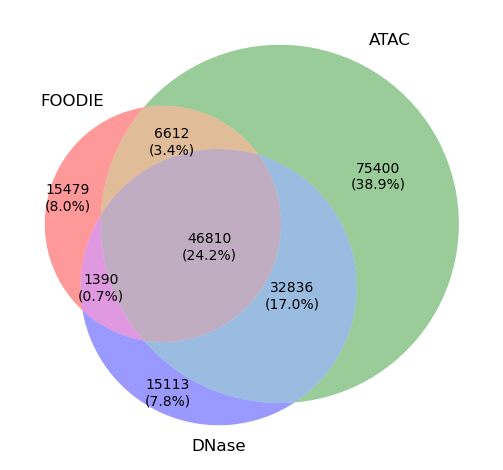

In [10]:
v = venn3([A, B, C], ('FOODIE', 'ATAC', 'DNase'))
for subset_id in ('100','010','001','110','101','011','111'):
    subset = v.get_label_by_id(subset_id)
    patch = v.get_patch_by_id(subset_id)
    if subset is None or patch is None:
        continue
    count = int(subset.get_text()) if subset.get_text() is not None else 0
    pct = 100.0 * count / union_size if union_size > 0 else 0.0
    subset.set_text(f"{count}\n({pct:.1f}%)")

plt.title('')
plt.tight_layout()
plt.show()

In [11]:
# footprint-based overlap analysis
K562_foodie_overlap_dict = {}
for assay in ['FOODIE', 'ATAC', 'DNase']:
    assay_pr = K562_assay_dict[assay][['Chromosome', 'Start', 'End']]
    K562_foodie_overlap = K562_foodie.join(assay_pr, suffix='_assay').df
    K562_foodie_overlap['assay'] = assay
    K562_foodie_overlap_dict[assay] = K562_foodie_overlap['Name'].unique().tolist()
A = set(K562_foodie_overlap_dict['FOODIE'])
B = set(K562_foodie_overlap_dict['ATAC'])
C = set(K562_foodie_overlap_dict['DNase'])
union_size = len(A | B | C)

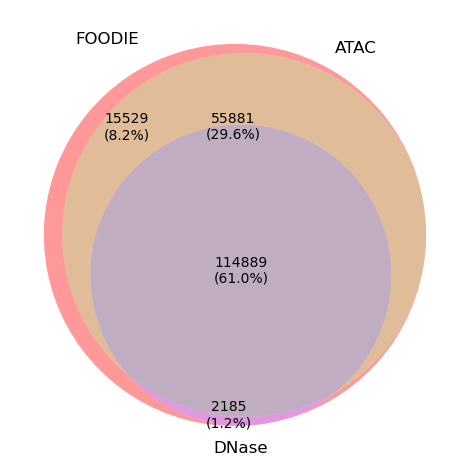

In [12]:
v = venn3([A, B, C], ('FOODIE', 'ATAC', 'DNase'))
for subset_id in ('100','010','001','110','101','011','111'):
    subset = v.get_label_by_id(subset_id)
    patch = v.get_patch_by_id(subset_id)
    if subset is None or patch is None:
        continue
    count = int(subset.get_text()) if subset.get_text() is not None else 0
    pct = 100.0 * count / union_size if union_size > 0 else 0.0
    subset.set_text(f"{count}\n({pct:.1f}%)")

plt.title('')
plt.tight_layout()
plt.savefig('K562_footprint_based_ATAC_DNase_overlap.pdf', transparent=True, bbox_inches='tight')

In [13]:
# footprint-based overlap analysis
GM12878_foodie_overlap_dict = {}
for assay in ['FOODIE', 'ATAC', 'DNase']:
    assay_pr = GM12878_assay_dict[assay][['Chromosome', 'Start', 'End']]
    GM12878_foodie_overlap = GM12878_foodie.join(assay_pr, suffix='_assay').df
    GM12878_foodie_overlap['assay'] = assay
    GM12878_foodie_overlap_dict[assay] = GM12878_foodie_overlap['Name'].unique().tolist()
A = set(GM12878_foodie_overlap_dict['FOODIE'])
B = set(GM12878_foodie_overlap_dict['ATAC'])
C = set(GM12878_foodie_overlap_dict['DNase'])
union_size = len(A | B | C)

In [80]:
# GM12878_merged_region_annots = {}
# for key in GM12878_assay_dict.keys():
#     assay_pr = GM12878_assay_dict[key][['Chromosome', 'Start', 'End']]
#     GM12878_merged_assay = GM12878_merged.join(assay_pr, suffix='_assay').df
#     GM12878_merged_assay['assay'] = key
#     GM12878_merged_region_annots[key] = GM12878_merged_assay['Name'].unique().tolist()
# A = set(GM12878_merged_region_annots['FOODIE'])
# B = set(GM12878_merged_region_annots['ATAC'])
# C = set(GM12878_merged_region_annots['DNase'])
# union_size = len(A | B | C)

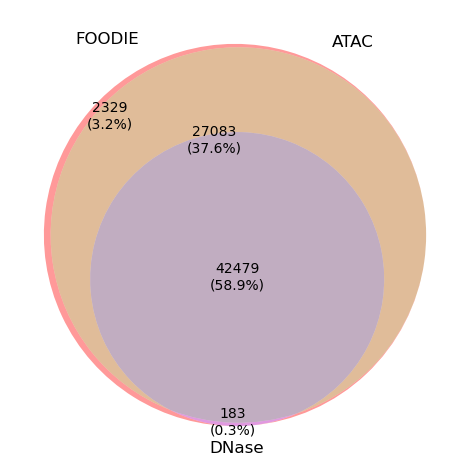

In [14]:
v = venn3([A, B, C], ('FOODIE', 'ATAC', 'DNase'))
for subset_id in ('100','010','001','110','101','011','111'):
    subset = v.get_label_by_id(subset_id)
    patch = v.get_patch_by_id(subset_id)
    if subset is None or patch is None:
        continue
    count = int(subset.get_text()) if subset.get_text() is not None else 0
    pct = 100.0 * count / union_size if union_size > 0 else 0.0
    subset.set_text(f"{count}\n({pct:.1f}%)")
plt.title('')
plt.tight_layout()
plt.show()

In [15]:
## ABC-fp generated CRE regions
cre_df = pd.read_csv('/cpl/home/linjc/tools/ABC_footprinting/FOODIE_ATAC_50bp_results/K562_FOODIE_ATAC/Neighborhoods/EnhancerList.txt', sep='\t')
cre_df['Length'] = (cre_df['end'] - cre_df['start']).astype(int)
cre_df['Length'].describe()

count    70670.000000
mean       686.771190
std        349.362214
min        499.000000
25%        500.000000
50%        534.000000
75%        706.000000
max      15188.000000
Name: Length, dtype: float64

In [ ]:
# df = pd.read_csv('./finemapping_results/HC_finemapping_allvars_hg38_K562_foodie.tsv', sep='\t')

In [2]:
def get_gwas_info(trait):
    gwas_fn = '../FOODIE_20250407/20250821_GWAS_common_results/{}.site_all_site_all_var_result.2025-08-06.txt'.format(trait)
    gwas_info = pd.read_csv(gwas_fn, sep='\t')
    return gwas_info

def get_var_info(trait):
    var_impute = []
    with open('/cpl/output/20250909_MCH_finemapping/result_jc/{}/{}.imputed.ma'.format(trait, trait), 'r') as f:
        for line in f:
            line = line.strip().split(' ')
            line = [x for x in line if x != '']
            var_impute.append(line)
    var_impute = pd.DataFrame(var_impute[1:], columns=var_impute[0])
    var_impute['freq'] = var_impute['freq'].astype(float)
    var_impute['b'] = var_impute['b'].astype(float)
    var_impute['p'] = var_impute['p'].astype(float)
    var_impute['N'] = var_impute['N'].astype(int)
    
    var_pip = []
    with open('/cpl/output/20250909_MCH_finemapping/result_jc/{}/{}.snpRes'.format(trait, trait), 'r') as f:
        for line in f:
            line = line.strip().split(' ')
            line = [x for x in line if x != '']
            var_pip.append(line)
    var_pip = pd.DataFrame(var_pip[1:], columns=var_pip[0])
    var_pip['PIP'] = var_pip['PIP'].astype(float)
    
    cs_info = []
    with open('/cpl/output/20250909_MCH_finemapping/result_jc/{}/{}.lcs'.format(trait, trait), 'r') as f:
        for line in f:
            line = line.strip().split(' ')
            line = [x for x in line if x != '']
            cs_info.append(line)
    cs_info = pd.DataFrame(cs_info[1:], columns=cs_info[0])
    
    var_cs = []
    for idx, row in cs_info.iterrows():
        snps = row['SNP'].split(',')
        for snp in snps:
            var_cs.append([int(row['CS']), float(row['PIP']), snp, int(row['Size'])])
    var_cs = pd.DataFrame(var_cs, columns=['CS_ID', 'PIP_cs', 'rsID', 'Size_cs'])
    return var_impute, var_pip, var_cs

def motif_scan_csVars(cell, trait='erythroid', fp_ext=0, seq_ext=30, pip_thr=10):
    #     seq_ext = 30
    # cell = 'GM12878'
    # trait = 'Lymphocyte'
    motifs = read_meme("../FOODIE_20250407/JASPAR_MEME/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt")
    # motifs = read_meme("./JASPAR_MEME/consensus_pwms.meme")
    hits = fimo(motifs, './fasta_for_fimo_fmcs/{}_{}_fpExt{}bp_pip{}_ref_seqExt{}bp.fa'.format(trait, cell, 0, pip_thr, seq_ext), threshold=0.0001)  
    his_df = []
    for h in hits:
        if h.empty:
            continue
        his_df.append(h)
    ref_hits_df = pd.concat(his_df, ignore_index=True)
    # print(ref_hits_df.iloc[0])
    ref_hits_df['motif_id'] = ref_hits_df['motif_name'].str.split(' ').str[0] + ref_hits_df['strand']
    ref_hits_df['motif_name'] = ref_hits_df['motif_name'].str.split(' ').str[1] + ref_hits_df['strand']
    ref_hits_df['motif_info'] = ref_hits_df['motif_id'] + '-' + ref_hits_df['motif_name'] + '_' + ref_hits_df['start'].astype(str) + '_' + ref_hits_df['end'].astype(str)
    ref_hits_df['var-motif'] = ref_hits_df['sequence_name'] + '-' + ref_hits_df['motif_info']
    ref_hits_df['foodie_id'] = ref_hits_df['sequence_name'].str.split('|').str[-1]
    ref_hits_df['rsID'] = ref_hits_df['sequence_name'].str.split('|').str[0]
    ref_hits_df['var_locus'] = ref_hits_df['sequence_name'].str.split('|').str[1]
    ref_hits_df['pos_var'] = ref_hits_df['var_locus'].str.split(':').str[1].astype(int)
    ref_hits_df['chrom_fp'] = ref_hits_df['foodie_id'].str.split(':').str[0]
    ref_hits_df['start_fp'] = ref_hits_df['foodie_id'].str.split(':').str[-1].str.split('-').str[0].astype(int)
    ref_hits_df['end_fp'] = ref_hits_df['foodie_id'].str.split(':').str[-1].str.split('-').str[1].astype(int)   
    ref_hits_df['pos_var_in_fp'] = ref_hits_df['pos_var'] - ref_hits_df['start_fp']
    ref_hits_df['start_motif'] = ref_hits_df['start'] - seq_ext + ref_hits_df['start_fp']
    ref_hits_df['end_motif'] = ref_hits_df['end'] - seq_ext + ref_hits_df['start_fp']
    ref_hits_df['var_in_motif'] = (ref_hits_df['pos_var'] >= ref_hits_df['start_motif']) & (ref_hits_df['pos_var'] <= ref_hits_df['end_motif'])
    ref_hits_df = ref_hits_df[ref_hits_df['var_in_motif']].reset_index(drop=True)

    hits = fimo(motifs, './fasta_for_fimo_fmcs/{}_{}_fpExt{}bp_pip{}_alt_seqExt{}bp.fa'.format(trait, cell, 0, pip_thr, seq_ext), threshold=0.0001)  
    his_df = []
    for h in hits:
        if h.empty:
            continue
        his_df.append(h)
    alt_hits_df = pd.concat(his_df, ignore_index=True)
    alt_hits_df['motif_id'] = alt_hits_df['motif_name'].str.split(' ').str[0] + alt_hits_df['strand']
    alt_hits_df['motif_name'] = alt_hits_df['motif_name'].str.split(' ').str[1] + alt_hits_df['strand']
    alt_hits_df['motif_info'] = alt_hits_df['motif_id'] + '-' + alt_hits_df['motif_name'] + '_' + alt_hits_df['start'].astype(str) + '_' + alt_hits_df['end'].astype(str)
    alt_hits_df['var-motif'] = alt_hits_df['sequence_name'] + '-' + alt_hits_df['motif_info' ] 
    alt_hits_df['foodie_id'] = alt_hits_df['sequence_name'].str.split('|').str[-1]
    alt_hits_df['rsID'] = alt_hits_df['sequence_name'].str.split('|').str[0]
    alt_hits_df['var_locus'] = alt_hits_df['sequence_name'].str.split('|').str[1]
    alt_hits_df['pos_var'] = alt_hits_df['var_locus'].str.split(':').str[1].astype(int)
    alt_hits_df['chrom_fp'] = alt_hits_df['foodie_id'].str.split(':').str[0]
    alt_hits_df['start_fp'] = alt_hits_df['foodie_id'].str.split(':').str[-1].str.split('-').str[0].astype(int)
    alt_hits_df['end_fp'] = alt_hits_df['foodie_id'].str.split(':').str[-1].str.split('-').str[1].astype(int)   
    alt_hits_df['pos_var_in_fp'] = alt_hits_df['pos_var'] - alt_hits_df['start_fp']
    alt_hits_df['start_motif'] = alt_hits_df['start'] - seq_ext + alt_hits_df['start_fp']
    alt_hits_df['end_motif'] = alt_hits_df['end'] - seq_ext + alt_hits_df['start_fp']
    alt_hits_df['var_in_motif'] = (alt_hits_df['pos_var'] >= alt_hits_df['start_motif']) & (alt_hits_df['pos_var'] <= alt_hits_df['end_motif'])
    alt_hits_df = alt_hits_df[alt_hits_df['var_in_motif']].reset_index(drop=True)
    ref_alt_hits_df = ref_hits_df.merge(alt_hits_df, suffixes=['_ref', '_alt'], on=['var-motif'], how='outer').reset_index(drop=True)
    ref_alt_hits_df['sequence_name'] = ref_alt_hits_df['sequence_name_ref'].fillna(ref_alt_hits_df['sequence_name_alt'])
    return ref_alt_hits_df, ref_hits_df, alt_hits_df

class FastaStringExtractor:
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream
    def close(self):
        return self.fasta.close()
        
seq_extractor = FastaStringExtractor('/cpl/home/linjc/reference_data/hg38.fa')

In [3]:
def plot_manhattan(ax, df, title, threshold=5e-8, ymax=None, sign='LOG10P', colors = ['skyblue', 'navy']):
    # colors = ['skyblue', 'navy'] 
    # Work on a copy so the original DataFrame is not modified
    df_plot = df.copy()
    df_plot['BP_cum'] = 0
    chrom_order = sorted(df_plot['CHROM'].unique(), key=lambda x: int(x))
    cum_bp = 0
    ticks = []
    labels = []
    for chrom in chrom_order:
        mask = df_plot['CHROM'] == chrom
        # Compute cumulative base pair positions
        df_plot.loc[mask, 'BP_cum'] = df_plot.loc[mask, 'GENPOS'] + cum_bp
        ticks.append(df_plot.loc[mask, 'BP_cum'].median())
        labels.append(chrom)
        cum_bp += df_plot.loc[mask, 'GENPOS'].max()
    
    # Plot points for each chromosome using alternating colors
    for i, chrom in enumerate(chrom_order):
        chrom_data = df_plot[df_plot['CHROM'] == chrom]
        # chrom_data_high_pip = chrom_data[chrom_data['PIP'] > 0.8]
        ax.scatter(chrom_data['BP_cum'], chrom_data[sign],
                   color=colors[i % len(colors)],
                   s=3, label=f'Chr {chrom}')
        # ax.scatter(chrom_data_high_pip['BP_cum'], chrom_data_high_pip[sign],
        #            color='green',
        #            s=5, label=f'Chr {chrom}')
    # ax.set_xlabel('Chromosome')
    ax.set_ylabel(sign)
    # ax.set_title(title)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    # Draw a significance threshold line (e.g., p-value = 5e-8)
    if threshold is not None:
        ax.axhline(threshold, color='red', linestyle='dashed', lw=1)
    ax.margins(x=0.01, y=0.02)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    # Remove unwanted spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # if ymax is not None:
    #     plt.ylim(0, ymax)

In [ ]:
# Load trait information
data_dir = './data'
trait_info = pd.read_csv(os.path.join(data_dir, 'blood_phenotype_classification_v2.csv')) # |(trait_info['Type'] == 'Platelets')|(trait_info['Type'] == 'Myeloid')|(trait_info['Type'] == 'Lymphoid')
# blood_traits = trait_info[(trait_in7869pl fo['Type'] == 'Erythroid')|(trait_info['Type'] == 'Platelets')|(trait_info['Type'] == 'Myeloid')|(trait_info['Type'] == 'Lymphoid')].reset_index(drop=True)
erythroid_traits = trait_info[trait_info['Type'] == 'Erythroid'].reset_index(drop=True)
K562_foodie = pr.read_bed(os.path.join(data_dir, 'FOODIE_footprints/K562.merged.hg38.bed'))[['Chromosome', 'Start', 'End', 'Name']]
K562_prot_coding_genes_dedup = pd.read_csv(os.path.join(data_dir, 'K562_prot_coding_genes_dedup.tsv'), sep='\t', index_col=0)
GM12878_prot_coding_genes_dedup = pd.read_csv(os.path.join(data_dir, 'GM12878_prot_coding_genes_dedup.tsv'), sep='\t', index_col=0)
gene_expr = {'K562': K562_prot_coding_genes_dedup, 'GM12878': GM12878_prot_coding_genes_dedup}
TF_K562_GM12878_merged = pd.read_csv(os.path.join(data_dir, 'TF_K562_GM12878_expression.csv'))

In [5]:
K562_foodie = pr.read_bed('../FOODIE_20250407/FOODIE_merged_footprints/K562.merged.hg38.bed')[['Chromosome', 'Start', 'End', 'Name']]

In [6]:
K562_foodie.length = K562_foodie.End - K562_foodie.Start

In [7]:
# pd.read_csv('./finemapping_results/MCV_finemapping_allvars_hg38_K562_foodie.tsv', sep='\t')

In [8]:
# Load all fine-mapping erythroid trait common variants
all_comvar_K562 = []
trait_list = []
for fn in tqdm(glob.glob('./finemapping_results/*_finemapping_allvars_hg38_K562_foodie.tsv')):
    df = pd.read_csv(fn, sep='\t')
    df['trait'] = os.path.basename(fn).split('_')[0]
    trait_list.append(os.path.basename(fn).split('_')[0])
    all_comvar_K562.append(df)
all_comvar_K562 = pd.concat(all_comvar_K562).reset_index(drop=True)
all_comvar_K562['GENPOS'] = all_comvar_K562['End'].astype(int)
all_comvar_K562['CHROM'] = all_comvar_K562['Chromosome'].str.replace('chr', '').astype(int)
all_comvar_K562 = all_comvar_K562.rename(columns={'Position':'Position_hg19'})

# hg38 variants loading
all_comvar_K562_dedup = all_comvar_K562[['Name', 'Chromosome', 'Start', 'End', 'A1', 'A2']].drop_duplicates().reset_index(drop=True)
for idx, row in tqdm(all_comvar_K562_dedup.iterrows(), total=len(all_comvar_K562_dedup)):
    chrom = row['Chromosome']
    a1_var = row['A2']
    a2_var = row['A1']
    var_pos_start = int(row['End'])-1
    chrom = row['Chromosome']
    ref_a1_var_seq = seq_extractor.extract(Interval(chrom, var_pos_start, var_pos_start+len(a1_var)))
    ref_a2_var_seq = seq_extractor.extract(Interval(chrom, var_pos_start, var_pos_start+len(a2_var)))
    if ref_a2_var_seq == a2_var:
        all_comvar_K562_dedup.loc[idx, 'which_ref'] = 'A2'
        all_comvar_K562_dedup.loc[idx, 'REF'] = a2_var
        all_comvar_K562_dedup.loc[idx, 'ALT'] = a1_var
    elif ref_a1_var_seq == a1_var:
        all_comvar_K562_dedup.loc[idx, 'which_ref'] = 'A1'
        all_comvar_K562_dedup.loc[idx, 'REF'] = a1_var
        all_comvar_K562_dedup.loc[idx, 'ALT'] = a2_var
    else:
        all_comvar_K562_dedup.loc[idx, 'which_ref'] = 'NA'
all_comvar_K562 = all_comvar_K562.merge(all_comvar_K562_dedup[['Name', 'which_ref', 'REF', 'ALT']], on='Name').dropna()

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 16063/16063 [00:06<00:00, 2551.69it/s]


In [9]:
all_comvar_K562[all_comvar_K562['PIP']>0.1]['Name'].nunique()

961

In [10]:
all_comvar_K562['Name'].nunique()

16055

In [11]:
# Load credible varaiant information
cs_info = []
for trait in trait_list:
    with open('/cpl/output/20250909_MCH_finemapping/result_jc/{}/{}.lcs'.format(trait, trait), 'r') as f:
        trait_cs_info = []
        for line in f:
            line = line.strip().split(' ')
            line = [x for x in line if x != '']
            trait_cs_info.append(line)
        trait_cs_info = pd.DataFrame(trait_cs_info[1:], columns=trait_cs_info[0])
        trait_cs_info['trait'] = trait
    cs_info.append(trait_cs_info)
cs_info = pd.concat(cs_info, ignore_index=True)
snp_cs = []
for idx, row in cs_info.iterrows():
    snps = row['SNP'].split(',')
    for snp in snps:
        snp_cs.append([row['CS'], row['PIP'], row['PEP'], snp, row['trait']])
snp_cs = pd.DataFrame(snp_cs, columns=['ID_cs', 'PIP_cs', 'PEP_cs', 'rsID', 'trait'])
# Convert columns to appropriate data types
snp_cs['PIP_cs'] = pd.to_numeric(snp_cs['PIP_cs'], errors='coerce')
snp_cs['PEP_cs'] = pd.to_numeric(snp_cs['PEP_cs'], errors='coerce')
snp_cs['ID_cs'] = pd.to_numeric(snp_cs['ID_cs'], errors='coerce')

Median: 1.0
Mean: 2.1


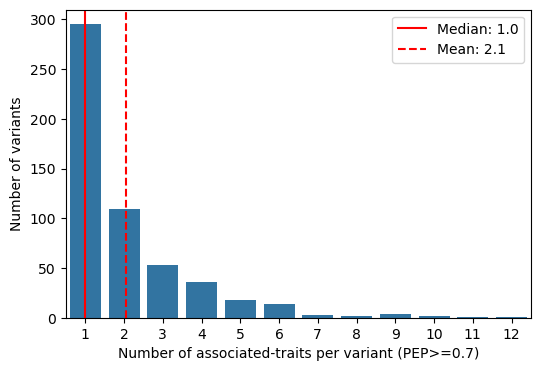

In [15]:
var_at_K562_foodie = list(set(all_comvar_K562['Name'].unique()).intersection(snp_cs['rsID'].unique()))
snp_cs_at_K562_fp = snp_cs.set_index('rsID').loc[var_at_K562_foodie].reset_index()
plt.figure(figsize=(6, 4))
ntraits_per_vars = snp_cs_at_K562_fp.groupby('rsID')['trait'].nunique().reset_index().groupby('trait').count().reset_index()
median_traits_per_var = snp_cs_at_K562_fp.groupby('rsID')['trait'].nunique().median()
mean_traits_per_var = snp_cs_at_K562_fp.groupby('rsID')['trait'].nunique().mean()
sns.barplot(data=ntraits_per_vars, x='trait', y='rsID')
print('Median: {:.1f}'.format(median_traits_per_var))
print('Mean: {:.1f}'.format(mean_traits_per_var))
plt.axvline(x=median_traits_per_var-1, color='r', linestyle='-', label='Median: {:.1f}'.format(median_traits_per_var))
plt.axvline(x=mean_traits_per_var-1, color='r', linestyle='--', label='Mean: {:.1f}'.format(mean_traits_per_var))
plt.xlabel('Number of associated-traits per variant (PEP>=0.7)')
plt.ylabel('Number of variants')
plt.legend()
# plt.savefig('figure4_pep70_per_num_traits.pdf', transparent=True, dpi=500)

In [12]:
# all_csvar_K562 = all_comvar_K562.merge(snp_cs, left_on='Name', right_on='rsID').reset_index(drop=True) 
all_comvar_K562_keepTopPIP = all_comvar_K562[['Name', 'trait', 'PIP', 'A1Effect']].sort_values(by=['Name', 'PIP'], ascending=[True, False]).drop_duplicates(subset=['Name'], keep='first').reset_index(drop=True)
snp_cs_dedup = snp_cs.sort_values(by=['rsID', 'PEP_cs'], ascending=[True, False]).drop_duplicates(subset=['rsID']).reset_index(drop=True)

In [13]:
all_comvar_K562_keepTopPIP[all_comvar_K562_keepTopPIP['PIP'] >= 0.1]['Name'].nunique()

961

In [14]:
# all_comvar_K562_keepTopPIP

In [15]:
# all_comvar_K562_keepTopPIP[all_comvar_K562_keepTopPIP['PIP'] > 0.1].shape

In [16]:
all_comvar_K562_keepTopPIP.merge(snp_cs_dedup.drop(columns=['trait']), left_on='Name', right_on='rsID', how='left').dropna().drop_duplicates().shape, all_comvar_K562_keepTopPIP.shape

((538, 8), (16055, 4))

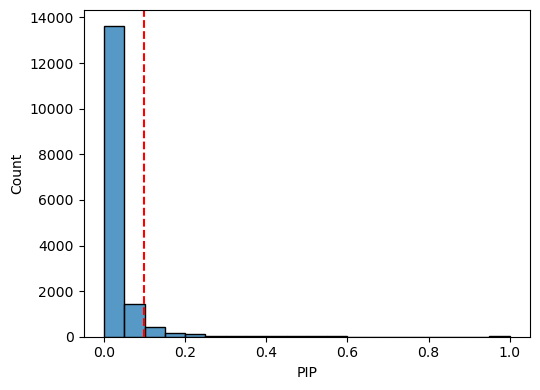

In [20]:
plt.figure(figsize=(5.5, 4))
sns.histplot(all_comvar_K562_keepTopPIP['PIP'], bins=20)
plt.axvline(x=0.1, color='r', linestyle='--')
# plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('./figure4_K562_PIP_hist.pdf', transparent=True)

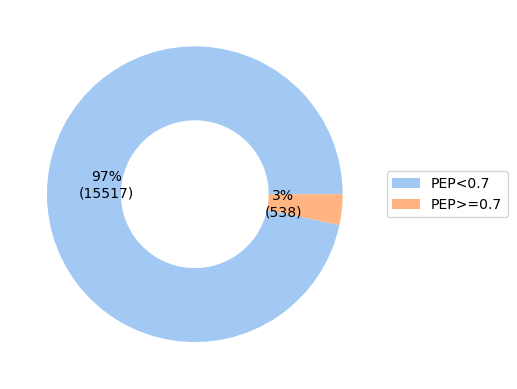

In [21]:
labels = ['PEP<0.7', 'PEP>=0.7']
data = [16055-538, 538]
colors = sns.color_palette('pastel')
fig, ax = plt.subplots()

# Custom function to display both percentage and value
def autopct_format(pct, all_vals):
    absolute = int(round(pct/100. * sum(all_vals)))
    return f"{pct:.0f}%\n({absolute})"

wedges, texts, autotexts = ax.pie(
    data,
    # labels=labels,
    colors=colors,
    startangle=0,
    autopct=lambda pct: autopct_format(pct, data),
    wedgeprops=dict(width=0.5)
)
ax.legend(wedges, labels, title="", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.savefig("figure4_common_pip_piechart.pdf", bbox_inches="tight", transparent=True)

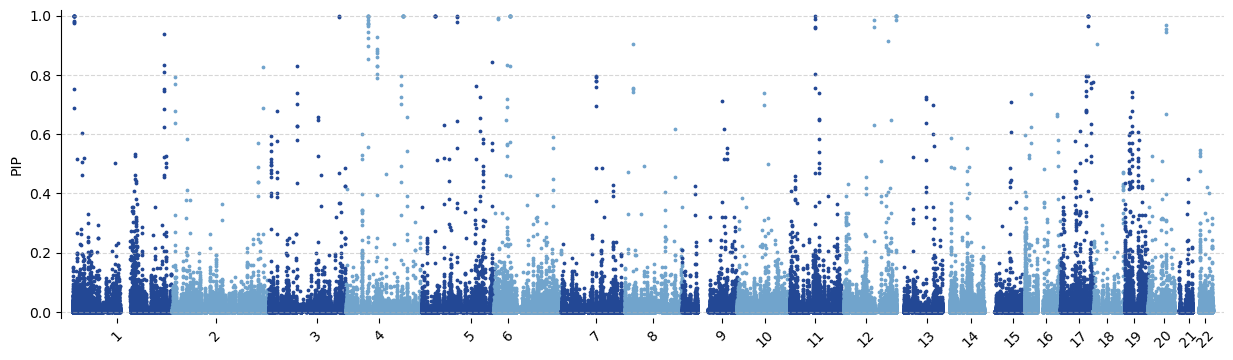

In [17]:
fig, ax1, = plt.subplots(nrows=1, figsize=(15, 4), sharex=True)
plot_manhattan(ax1, all_comvar_K562, title='', sign='PIP', threshold=None, colors= ['#234895', '#71a4cc'])
# plot_manhattan(ax2, all_rarevar_K562, title='', threshold=-np.log10(0.05/len(K562_foodie)), sign='LOG10P', colors= ['#2e6834', '#86b979'])
# plt.subplots_adjust(hspace=0.1)
plt.savefig('./erythroid_common_manhattan.png', dpi=1000, transparent=True, bbox_inches='tight')

In [20]:
fp_ext = 0
ext_bp = 30
pip_thr = 0
cell = 'K562'
ref_alt_csVar, ref_hits_csVar, alt_hits_csVar = motif_scan_csVars(cell, 'erythroid', fp_ext=0, seq_ext=ext_bp, pip_thr=pip_thr)
for idx, row in ref_alt_csVar.iterrows():
    rsid, var_id, fp_id = row['sequence_name'].split('|')
    var_id = ':'.join(var_id.replace('DRAGEN:', '').split(':')[:-1]) + '>' + var_id.replace('DRAGEN:', '').split(':')[-1]
    # ref_alt_csVar.at[idx, 'sequence_name'] = ref_alt_csVar.at[idx, 'sequence_name'].split('|')[0]
    ref_alt_csVar.at[idx, 'variant_id'] = var_id
    ref_alt_csVar.at[idx, 'foodie_id'] = fp_id
    ref_alt_csVar.at[idx, 'rsID'] = rsid
ref_alt_csVar['p-value_ref'] = ref_alt_csVar['p-value_ref'].fillna(1)
ref_alt_csVar['p-value_alt'] = ref_alt_csVar['p-value_alt'].fillna(1)
for idx, row in tqdm(ref_alt_csVar.iterrows(),  total=ref_alt_csVar.shape[0]):
    if row['p-value_ref'] != 1 and row['p-value_alt'] != 1:
        if row['p-value_ref'] > row['p-value_alt']:
            ref_alt_csVar.at[idx, 'TF_change'] = 'Increase'
        elif row['p-value_ref'] < row['p-value_alt']:
            ref_alt_csVar.at[idx, 'TF_change'] = 'Decrease'
        else:
            ref_alt_csVar.at[idx, 'TF_change'] = 'Unchange'
    elif row['p-value_ref'] == 1 and row['p-value_alt'] != 1:
        ref_alt_csVar.at[idx, 'TF_change'] = 'Create'
    elif row['p-value_ref'] != 1 and row['p-value_alt'] == 1:
        ref_alt_csVar.at[idx, 'TF_change'] = 'Disrupt'
    else:
        ref_alt_csVar.at[idx, 'TF_change'] = 'NoTFBS'
# ref_alt_csVar_change_df = ref_alt_csVar[ref_alt_csVar['TF_change'] != 'Unchange'].reset_index(drop=True)
ref_alt_csVar['cell'] = cell
# ref_alt_csVar['trait'] = 'erythroid'
ref_alt_csVar['rsID'] = ref_alt_csVar['rsID_ref'].fillna(ref_alt_csVar['rsID_alt'])
ref_alt_csVar['TF'] = ref_alt_csVar['motif_name_ref'].fillna(ref_alt_csVar['motif_name_alt']).str[:-1].str.upper()
# ref_alt_csVar = ref_alt_csVar.merge(TF_K562_GM12878_merged[['TF', '{}_rna_tpm'.format(cell)]], on='TF').reset_index(drop=True).rename(columns={'{}_rna_tpm'.format(cell):'TF_{}_rna_tpm'.format(cell)})
# corrected tfbs
var_tfbs_alt_ref_all = []
for rsid in tqdm(ref_alt_csVar['rsID'].unique()):
    var_tfbs = ref_alt_csVar[ref_alt_csVar['rsID'] == rsid].reset_index(drop=True)
    foodie_id = var_tfbs.at[0, 'foodie_id']
    var_tfbs_ref = var_tfbs[['TF', 'motif_name_ref', 'motif_id_ref', 'p-value_ref', 'start_ref', 'end_ref']].reset_index(drop=True).dropna()
    var_tfbs_ref = var_tfbs_ref.sort_values(by=['TF', 'p-value_ref']).drop_duplicates(subset=['TF'], keep='first').reset_index(drop=True)
    var_tfbs_alt = var_tfbs[['TF', 'motif_name_alt', 'motif_id_alt', 'p-value_alt', 'start_alt', 'end_alt']].reset_index(drop=True).dropna()
    var_tfbs_alt = var_tfbs_alt.sort_values(by=['TF', 'p-value_alt']).drop_duplicates(subset=['TF'], keep='first').reset_index(drop=True)
    var_tfbs_alt_ref = var_tfbs_ref.merge(var_tfbs_alt, on='TF', how='outer').reset_index(drop=True)
    var_tfbs_alt_ref['rsID'] = rsid
    var_tfbs_alt_ref['foodie_id'] = foodie_id
    var_tfbs_alt_ref_all.append(var_tfbs_alt_ref)
var_tfbs_alt_ref_all = pd.concat(var_tfbs_alt_ref_all).reset_index(drop=True)
var_tfbs_alt_ref_all['p-value_ref'] = var_tfbs_alt_ref_all['p-value_ref'].fillna(1)
var_tfbs_alt_ref_all['p-value_alt'] = var_tfbs_alt_ref_all['p-value_alt'].fillna(1)
for idx, row in tqdm(var_tfbs_alt_ref_all.iterrows(),  total=var_tfbs_alt_ref_all.shape[0]):
    if row['p-value_ref'] != 1 and row['p-value_alt'] != 1:
        if row['p-value_ref'] > row['p-value_alt']:
            var_tfbs_alt_ref_all.at[idx, 'TF_change'] = 'Increase'
        elif row['p-value_ref'] < row['p-value_alt']:
            var_tfbs_alt_ref_all.at[idx, 'TF_change'] = 'Decrease'
        else: 
            var_tfbs_alt_ref_all.at[idx, 'TF_change'] = 'Unchange'
    elif row['p-value_ref'] == 1 and row['p-value_alt'] != 1:
        var_tfbs_alt_ref_all.at[idx, 'TF_change'] = 'Create'
    elif row['p-value_ref'] != 1 and row['p-value_alt'] == 1:
        var_tfbs_alt_ref_all.at[idx, 'TF_change'] = 'Disrupt'
    else:
        var_tfbs_alt_ref_all.at[idx, 'TF_change'] = 'NoTFBS'
var_tfbs_alt_ref_all = var_tfbs_alt_ref_all.merge(TF_K562_GM12878_merged[['TF', '{}_rna_tpm'.format(cell)]], on='TF', how='left').reset_index(drop=True).rename(columns={'{}_rna_tpm'.format(cell):'TF_{}_rna_tpm'.format(cell)})

100%|██████████| 80843/80843 [00:04<00:00, 16692.89it/s]


In [21]:
var_tfbs_alt_ref_all['rsID'].nunique()  

14357

In [22]:
pip_threshold = 0.1
var_in_cs = True
var_tfbs_alt_ref_pip = var_tfbs_alt_ref_all.merge(all_comvar_K562_keepTopPIP.rename(columns={'Name':'rsID'}), on='rsID')# .to_csv('./figure4_K562_erythroid_comvar_pip10_tfbs_changes.tsv', sep='\t', index=False)
var_tfbs_alt_ref_pip_cs = var_tfbs_alt_ref_pip.merge(snp_cs_dedup.drop(columns=['trait']), on='rsID', how='left').reset_index(drop=True)
if var_in_cs:
    var_tfbs_alt_ref_filtered = var_tfbs_alt_ref_pip_cs[(var_tfbs_alt_ref_pip_cs['PIP'] >= pip_threshold)&(~var_tfbs_alt_ref_pip_cs['PEP_cs'].isna())]
else:
    var_tfbs_alt_ref_filtered = var_tfbs_alt_ref_pip[(var_tfbs_alt_ref_pip['PIP'] >= pip_threshold)]
var_tfbs_change_event_count = var_tfbs_alt_ref_filtered.groupby('TF_change').size().reset_index(name='count').reset_index()

In [23]:
snp_cs_dedup

,ID_cs,PIP_cs,PEP_cs,rsID,trait
0,979,0.917164,0.74625,10:101077864_ATAAAAT_A,RBCDW
1,970,0.908293,0.79000,10:101254508_CTCTTCTT_C,RBCDW
2,970,0.908293,0.79000,10:101258103_CA_C,RBCDW
3,1040,0.903218,0.72500,10:101267668_GA_G,MSCV
4,1040,0.903218,0.72500,10:101268129_AG_A,MSCV
...,...,...,...,...,...
103089,502,0.912620,0.78375,rs9998785,RBCDW
103090,1124,0.900616,0.70375,rs9999362,MSCV
103091,725,0.906655,0.73375,rs999951,RC
103092,584,0.915454,0.71500,rs999958,HLDRC


In [24]:
all_comvar_K562_keepTopPIP_PEP = all_comvar_K562_keepTopPIP.merge(snp_cs_dedup.drop(columns='trait'), left_on='Name', right_on='rsID').reset_index(drop=True)
all_comvar_K562_keepTopPIP_PEP[all_comvar_K562_keepTopPIP_PEP['PIP'] > 0.1]

,Name,trait,PIP,A1Effect,ID_cs,PIP_cs,PEP_cs,rsID
0,11:61659120_AC_A,MCH,0.104171,0.001309,384,0.905684,0.83000,11:61659120_AC_A
2,13:110439576_TC_T,MCH,0.243873,-0.001758,618,0.960099,0.82375,13:110439576_TC_T
8,19:19432290_AG_A,RBC,0.323378,0.007095,702,1.029108,0.77250,19:19432290_AG_A
11,20:54987048_CTCA_C,RBCDW,0.279107,0.003331,592,0.946795,0.83000,20:54987048_CTCA_C
12,3:171528283_GGA_G,RBCDW,0.320437,-0.007307,343,0.923610,0.89875,3:171528283_GGA_G
...,...,...,...,...,...,...,...,...
524,rs9465733,RBC,0.334997,0.002217,593,0.965474,0.81125,rs9465733
527,rs9525462,RBC,0.524607,-0.005189,648,0.903288,0.79250,rs9525462
528,rs960499,RBC,0.491295,-0.007289,497,0.936634,0.79125,rs960499
533,rs9901161,MCH,0.158075,-0.001036,333,0.907250,0.70125,rs9901161


In [25]:
var_tfbs_alt_ref_pip_cs['rsID'].nunique(), all_comvar_K562_keepTopPIP['Name'].nunique()

(14357, 16055)

In [26]:
var_tfbs_alt_ref_pip_cs[(var_tfbs_alt_ref_pip_cs['PIP']>0.1)&(~var_tfbs_alt_ref_pip_cs['PEP_cs'].isna())]['rsID'].nunique()

230

In [27]:
var_tfbs_alt_ref_pip_cs

,TF,motif_name_ref,motif_id_ref,p-value_ref,start_ref,end_ref,motif_name_alt,motif_id_alt,p-value_alt,start_alt,...,rsID,foodie_id,TF_change,TF_K562_rna_tpm,trait,PIP,A1Effect,ID_cs,PIP_cs,PEP_cs
0,PLAG1,NaN,NaN,1.000000,NaN,NaN,PLAG1-,MA0163.1-,0.000078,33.0,...,10:101380709_TC_T,chr10:99620948-99620964,Create,0.211299,MCV,0.023502,0.000010,NaN,NaN,NaN
1,YY1,Yy1+,MA0095.4+,0.000031,35.0,43.0,Yy1+,MA0095.4+,0.000031,35.0,...,10:102214257_TG_T,chr10:100454489-100454503,Unchange,10.242900,RP,0.003159,-0.000049,NaN,NaN,NaN
2,ZFP42,ZFP42+,MA1651.2+,0.000034,35.0,48.0,NaN,NaN,1.000000,NaN,...,10:102214257_TG_T,chr10:100454489-100454503,Disrupt,0.054321,RP,0.003159,-0.000049,NaN,NaN,NaN
3,NR1D1,NaN,NaN,1.000000,NaN,NaN,NR1D1-,MA1531.2-,0.000003,50.0,...,10:103336523_GTGACATAT_G,chr10:101576746-101576770,Create,0.263448,MCV,0.015547,0.000954,NaN,NaN,NaN
4,NR1D2,NaN,NaN,1.000000,NaN,NaN,NR1D2-,MA1532.2-,0.000001,50.0,...,10:103336523_GTGACATAT_G,chr10:101576746-101576770,Create,0.221327,MCV,0.015547,0.000954,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80838,MGA,MGA-,MA0801.1-,0.000076,36.0,44.0,NaN,NaN,1.000000,NaN,...,rs9988580,chr1:44730945-44730971,Disrupt,2.711040,MSCV,0.148641,-0.000192,NaN,NaN,NaN
80839,MSANTD3,MSANTD3+,MA1523.2+,0.000061,33.0,40.0,NaN,NaN,1.000000,NaN,...,rs9988580,chr1:44730945-44730971,Disrupt,3.724320,MSCV,0.148641,-0.000192,NaN,NaN,NaN
80840,SREBF1,SREBF1+,MA0595.1+,0.000039,35.0,45.0,NaN,NaN,1.000000,NaN,...,rs9988580,chr1:44730945-44730971,Disrupt,7.857860,MSCV,0.148641,-0.000192,NaN,NaN,NaN
80841,SREBF2,SREBF2-,MA0596.1-,0.000075,35.0,45.0,NaN,NaN,1.000000,NaN,...,rs9988580,chr1:44730945-44730971,Disrupt,4.792790,MSCV,0.148641,-0.000192,NaN,NaN,NaN


In [28]:
var_affected_tfbs = set(var_tfbs_alt_ref_filtered[var_tfbs_alt_ref_filtered['TF_change'] != 'Unchange']['rsID'])
len(var_affected_tfbs)

221

In [33]:
# var_tfbs_alt_ref_filtered['rsID'].nunique()

In [34]:
# var_tfbs_alt_ref_filtered

In [22]:
# var_tfbs_alt_ref_filtered['rsID'].nunique()

In [23]:
# # 221/230 
# var_tfbs_alt_ref_filtered['TF_change'].unique()

In [29]:
var_tfbs_alt_ref_effected = var_tfbs_alt_ref_filtered[var_tfbs_alt_ref_filtered['TF_change'] != 'Unchange'].reset_index(drop=True)
TF_change_event_count = var_tfbs_alt_ref_effected.groupby(['TF', 'TF_change']).size().reset_index().rename(columns={0:'count'})

In [30]:
var_tfbs_alt_ref_effected.to_csv('./final_results_260126/K562_crediblevars_tfbs_effected_full.csv', index=False)

In [31]:
var_tfbs_alt_ref_effected

,TF,motif_name_ref,motif_id_ref,p-value_ref,start_ref,end_ref,motif_name_alt,motif_id_alt,p-value_alt,start_alt,...,rsID,foodie_id,TF_change,TF_K562_rna_tpm,trait,PIP,A1Effect,ID_cs,PIP_cs,PEP_cs
0,EGR1,NaN,NaN,1.000000,NaN,NaN,EGR1+,MA0162.5+,0.000097,44.0,...,11:61659120_AC_A,chr11:61891633-61891654,Create,3.026930,MCH,0.104171,0.001309,384.0,0.905684,0.83000
1,EGR3,NaN,NaN,1.000000,NaN,NaN,EGR3+,MA0732.2+,0.000032,44.0,...,11:61659120_AC_A,chr11:61891633-61891654,Create,0.061496,MCH,0.104171,0.001309,384.0,0.905684,0.83000
2,EGR4,NaN,NaN,1.000000,NaN,NaN,EGR4+,MA0733.2+,0.000088,44.0,...,11:61659120_AC_A,chr11:61891633-61891654,Create,0.000000,MCH,0.104171,0.001309,384.0,0.905684,0.83000
3,GLI3,GLI3+,MA1491.3+,0.000045,42.0,57.0,NaN,NaN,1.000000,NaN,...,11:61659120_AC_A,chr11:61891633-61891654,Disrupt,0.000000,MCH,0.104171,0.001309,384.0,0.905684,0.83000
4,GLIS1,GLIS1+,MA0735.2+,0.000004,42.0,57.0,NaN,NaN,1.000000,NaN,...,11:61659120_AC_A,chr11:61891633-61891654,Disrupt,0.000000,MCH,0.104171,0.001309,384.0,0.905684,0.83000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,NRF1,Nrf1+,MA0506.3+,0.000029,32.0,44.0,NaN,NaN,1.000000,NaN,...,rs9901161,chr17:7484267-7484291,Disrupt,2.269920,MCH,0.158075,-0.001036,333.0,0.907250,0.70125
1192,ZNF213,ZNF213+,MA2121.1+,0.000064,34.0,46.0,NaN,NaN,1.000000,NaN,...,rs9901161,chr17:7484267-7484291,Disrupt,0.212367,MCH,0.158075,-0.001036,333.0,0.907250,0.70125
1193,INSM1,INSM1+,MA0155.1+,0.000045,24.0,36.0,INSM1+,MA0155.1+,0.000052,24.0,...,rs9908045,chr17:78169017-78169028,Decrease,0.000000,HC,0.603757,-0.003540,293.0,0.924888,0.77875
1194,ZNF454,ZNF454+,MA1712.2+,0.000026,35.0,52.0,NaN,NaN,1.000000,NaN,...,rs9908045,chr17:78169017-78169028,Disrupt,0.000000,HC,0.603757,-0.003540,293.0,0.924888,0.77875


In [32]:
# TF_change_event_count[TF_change_event_count['TF'].str.startswith('KLF')] 

In [33]:
# var_tfbs_alt_ref_filtered.to_csv('./results_20251224/commonvar_tfbs_alt_ref_filtered.tsv', sep='\t', index=False)

In [40]:
# TF_change_event_count
for change_type in ['Create', 'Increase', 'Decrease', 'Disrupt']:
    tf_affected_type = TF_change_event_count[TF_change_event_count['TF_change'] == change_type].sort_values(by='count', ascending=False).reset_index(drop=True)
    print(tf_affected_type.head(5))

       TF TF_change  count
0  ZNF460    Create      8
1    CTCF    Create      8
2  TFAP2C    Create      7
3  TFAP2A    Create      7
4     SP1    Create      7
       TF TF_change  count
0    CTCF  Increase     10
1   PRDM9  Increase      7
2   PATZ1  Increase      5
3  ZNF460  Increase      5
4   GLIS2  Increase      5
       TF TF_change  count
0    CTCF  Decrease     10
1   PATZ1  Decrease      6
2   PRDM9  Decrease      6
3   ZNF93  Decrease      4
4  ZNF460  Decrease      4
       TF TF_change  count
0    CTCF   Disrupt     11
1   KLF11   Disrupt      8
2     SP1   Disrupt      7
3   KLF16   Disrupt      7
4  TFAP2C   Disrupt      7


/tmp/ipykernel_4008171/3915502886.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


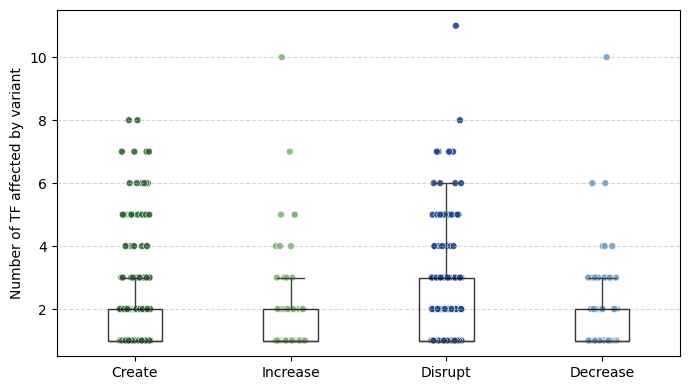

In [41]:
plt.figure(figsize=(7, 4))
sns.boxplot(
    data=TF_change_event_count, 
    x='TF_change', 
    y='count', 
    showfliers=False, 
    width=0.35, 
    boxprops={'facecolor': 'none', 'edgecolor': 'black', 'alpha': 0.8},  # Transparent box
    order=['Create', 'Increase', 'Disrupt', 'Decrease'],
    zorder=3
)
sns.stripplot(
    data=TF_change_event_count, 
    x='TF_change', 
    y='count', 
    palette={'Disrupt': '#1f458d', 'Decrease': '#6e9dc3', 'Create': '#2d6533', 'Increase': '#82b376'},
    alpha=0.9, 
    s=5,
    jitter=True, 
    zorder=0,
    linewidth=0.5,
    edgecolor='white',
    order=['Create', 'Increase', 'Disrupt', 'Decrease'],
)
plt.xlim(-0.5, 3.5)  
plt.grid(axis='y', ls  ='--', alpha=0.5)
plt.xlabel('')
plt.ylabel('Number of TF affected by variant')
plt.tight_layout()
plt.savefig('figure4_TF_affected_by_var_stripplot.pdf', transparent=True)

/tmp/ipykernel_1054091/3165261947.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


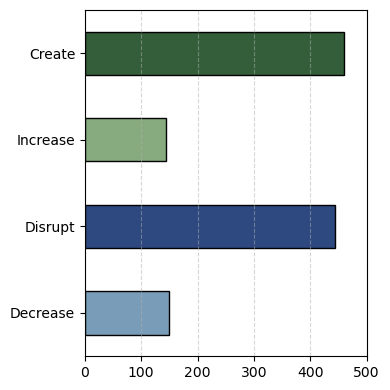

In [28]:
plt.figure(figsize=(4, 4))  # Adjusted figure size for horizontal layout
ax = sns.barplot(
    data=var_tfbs_change_event_count, 
    x='count',  # Swap x and y
    y='TF_change',  # Swap x and y
    palette={'Disrupt': '#1f458d', 'Decrease': '#6e9dc3', 'Create': '#2d6533', 'Increase': '#82b376'},
    width=0.5, 
    linewidth=0.5, 
    # linecolor='black', 
    # color='white', 
    order=['Create', 'Increase', 'Disrupt', 'Decrease']
)
for bar in ax.patches:
    bar.set_edgecolor('black')  # Set the desired edge color
    bar.set_linewidth(1)     
plt.grid(axis='x', ls='--', alpha=0.5)  # Change grid to align with horizontal bars
plt.xlim(0, 500)  # Adjust x-axis limit
plt.ylabel('')  # Clear y-axis label
plt.xlabel('')
plt.tight_layout()
plt.savefig('figure4_TFBS_effect_count_PIP50.pdf', transparent=True, bbox_inches='tight')

In [34]:
print('processing fp2gene...')
K562_atac = pr.read_bed('/cpl/home/linjc/tools/ABC_footprinting/FOODIE_ATAC_50bp_nopro_results/K562_FOODIE_ATAC//Neighborhoods/EnhancerList.bed')
K562_foodie = pr.read_bed('../FOODIE_20250407/FOODIE_merged_footprints/K562.merged.hg38.bed')
K562_foodie_atac = K562_foodie.join(K562_atac, suffix='_ATAC').df.reset_index()
# GM12878_atac = pr.read_bed('/cpl/home/linjc/tools/ABC_footprinting/FOODIE_ATAC_50bp_nopro_results/GM12878_FOODIE_ATAC/Neighborhoods/EnhancerList.bed')
# GM12878_foodie = pr.read_bed('../FOODIE_20250407/FOODIE_merged_footprints/GM12878.merged.hg38.bed')
# GM12878_foodie_atac = GM12878_foodie.join(GM12878_atac, suffix='_ATAC').df.reset_index()
# GM12878_foodie_atac['Length_ATAC'] = GM12878_foodie_atac['End_ATAC'] - GM12878_foodie_atac['Start_ATAC']
# GM12878_foodie_atac['Length_foodie'] = GM12878_foodie_atac['End'] - GM12878_foodie_atac['Start']
K562_foodie_atac['Length_ATAC'] = K562_foodie_atac['End_ATAC'] - K562_foodie_atac['Start_ATAC']
K562_foodie_atac['Length_foodie'] = K562_foodie_atac['End'] - K562_foodie_atac['Start']

K562_links = pd.read_csv('/cpl/home/linjc/tools/ABC_footprinting/FOODIE_ATAC_50bp_nopro_results/K562_FOODIE_ATAC/Predictions/EnhancerPredictionsAllPutative.tsv.gz', sep='\t')
K562_links['ABC.Score.v1'] = K562_links['activity_base']*K562_links['hic_contact']
K562_links['ABC.Score.v1'] = K562_links['ABC.Score.v1']/K562_links.groupby('TargetGene')['ABC.Score.v1'].transform('sum')
# K562_links = K562_links[K562_links['ABC.Score']>0.015].reset_index(drop=True)
# GM12878_links = pd.read_csv('/cpl/home/linjc/tools/ABC_footprinting/FOODIE_ATAC_50bp_nopro_results/GM12878_FOODIE_ATAC/Predictions/EnhancerPredictionsAllPutative.tsv.gz', sep='\t')
# GM12878_links = GM12878_links[GM12878_links['ABC.Score']>0.015].reset_index(drop=True)
K562_fp_atac_gene = K562_links[['name', 'class', 'TargetGene', 'distance', 'isSelfPromoter', 'hic_contact', 'activity_base', 'ABC.Score', 'ABC.Score.v1']].merge(K562_foodie_atac[['Name_ATAC','Length_ATAC', 'Length_foodie', 'Name']], left_on='name', right_on='Name_ATAC').reset_index(drop=True)
# GM12878_fp_atac_gene = GM12878_links[['name', 'class', 'TargetGene', 'distance', 'isSelfPromoter','hic_contact', 'activity_base', 'ABC.Score']].merge(GM12878_foodie_atac[['Name_ATAC','Length_ATAC','Length_foodie', 'Name']], left_on='name', right_on='Name_ATAC').reset_index(drop=True)

processing fp2gene...


In [28]:
# K562_fp_atac_gene['distance'].describe()

In [55]:
# K562_links[K562_links['TargetGene'] == 'CCND3']['TargetGeneTSS']

In [35]:
K562_fp_atac_gene_var = K562_fp_atac_gene.merge(var_tfbs_alt_ref_pip_cs[var_tfbs_alt_ref_pip_cs['TF_change'] != 'Unchange'][['rsID', 'foodie_id', 'PIP', 'PEP_cs']].drop_duplicates(), left_on='Name', right_on='foodie_id').reset_index(drop=True)
K562_fp_atac_gene_var_dedup = K562_fp_atac_gene_var.sort_values(by=['rsID','ABC.Score'], ascending=[True, False]).drop_duplicates(subset=['rsID'], keep='first').reset_index(drop=True)
K562_fp_atac_gene_var_filtered = K562_fp_atac_gene_var_dedup[(K562_fp_atac_gene_var_dedup['ABC.Score'] > 0.015)&(K562_fp_atac_gene_var_dedup['PIP'] > 0.1)&(~K562_fp_atac_gene_var_dedup['PEP_cs'].isna())].reset_index(drop=True)

In [36]:
K562_fp_atac_gene_var_filtered.groupby('class').size().reset_index(name='count')

,class,count
0,genic,48
1,intergenic,39
2,promoter,119


In [39]:
K562_fp_atac_gene_var_filtered

,name,class,TargetGene,distance,isSelfPromoter,hic_contact,activity_base,ABC.Score,ABC.Score.v1,Name_ATAC,Length_ATAC,Length_foodie,Name,rsID,foodie_id,PIP,PEP_cs
0,promoter|chr11:61890374-61892109,promoter,FADS3,303.5,True,0.062834,8.799785,1.000000,0.105354,promoter|chr11:61890374-61892109,1735,21,chr11:61891633-61891654,11:61659120_AC_A,chr11:61891633-61891654,0.104171,0.83000
1,promoter|chr19:19320271-19321742,promoter,SUGP1,494.5,True,0.082409,19.023542,1.000000,0.455851,promoter|chr19:19320271-19321742,1471,27,chr19:19321479-19321506,19:19432290_AG_A,chr19:19321479-19321506,0.323378,0.77250
2,promoter|chr3:171809418-171810874,promoter,PLD1,348.0,True,0.060085,11.228295,1.000000,0.367095,promoter|chr3:171809418-171810874,1456,30,chr3:171810484-171810514,3:171528283_GGA_G,chr3:171810484-171810514,0.320437,0.89875
3,promoter|chr5:73497822-73499110,promoter,BTF3,42.0,True,0.082541,26.157506,1.000000,0.612225,promoter|chr5:73497822-73499110,1288,13,chr5:73498410-73498423,5:72794248_CT_C,chr5:73498410-73498423,0.152295,0.70625
4,promoter|chr7:129952363-129953374,promoter,UBE2H,91.5,True,0.076927,7.931282,1.000000,0.191167,promoter|chr7:129952363-129953374,1011,30,chr7:129952692-129952722,7:129592540_CG_C,chr7:129952692-129952722,0.223285,0.72000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,promoter|chr1:25429686-25431642,promoter,TMEM57,193.0,True,0.087523,28.641906,1.000000,0.551154,promoter|chr1:25429686-25431642,1956,11,chr1:25430367-25430378,rs9438904,chr1:25430367-25430378,0.124720,0.72875
202,genic|chr6:20409252-20410137,genic,E2F3,7789.5,False,0.043243,14.374304,0.093345,0.107737,genic|chr6:20409252-20410137,885,16,chr6:20409542-20409558,rs9465733,chr6:20409542-20409558,0.334997,0.81125
203,promoter|chr13:41194057-41194905,promoter,KBTBD7,94.0,True,0.089085,7.451075,1.000000,0.385453,promoter|chr13:41194057-41194905,848,12,chr13:41194547-41194559,rs9525462,chr13:41194547-41194559,0.524607,0.79250
204,promoter|chr17:7483709-7485223,promoter,ZBTB4,217.0,True,0.065219,20.038358,1.000000,0.187209,promoter|chr17:7483709-7485223,1514,24,chr17:7484267-7484291,rs9901161,chr17:7484267-7484291,0.158075,0.70125


In [40]:
K562_fp_atac_gene_var_filtered #.drop(columns=['PIP', 'PEP_cs']).to_csv('./final_results_260126/K562_crediblevars_target_gene.csv', index=False)

,name,class,TargetGene,distance,isSelfPromoter,hic_contact,activity_base,ABC.Score,ABC.Score.v1,Name_ATAC,Length_ATAC,Length_foodie,Name,rsID,foodie_id,PIP,PEP_cs
0,promoter|chr11:61890374-61892109,promoter,FADS3,303.5,True,0.062834,8.799785,1.000000,0.105354,promoter|chr11:61890374-61892109,1735,21,chr11:61891633-61891654,11:61659120_AC_A,chr11:61891633-61891654,0.104171,0.83000
1,promoter|chr19:19320271-19321742,promoter,SUGP1,494.5,True,0.082409,19.023542,1.000000,0.455851,promoter|chr19:19320271-19321742,1471,27,chr19:19321479-19321506,19:19432290_AG_A,chr19:19321479-19321506,0.323378,0.77250
2,promoter|chr3:171809418-171810874,promoter,PLD1,348.0,True,0.060085,11.228295,1.000000,0.367095,promoter|chr3:171809418-171810874,1456,30,chr3:171810484-171810514,3:171528283_GGA_G,chr3:171810484-171810514,0.320437,0.89875
3,promoter|chr5:73497822-73499110,promoter,BTF3,42.0,True,0.082541,26.157506,1.000000,0.612225,promoter|chr5:73497822-73499110,1288,13,chr5:73498410-73498423,5:72794248_CT_C,chr5:73498410-73498423,0.152295,0.70625
4,promoter|chr7:129952363-129953374,promoter,UBE2H,91.5,True,0.076927,7.931282,1.000000,0.191167,promoter|chr7:129952363-129953374,1011,30,chr7:129952692-129952722,7:129592540_CG_C,chr7:129952692-129952722,0.223285,0.72000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,promoter|chr1:25429686-25431642,promoter,TMEM57,193.0,True,0.087523,28.641906,1.000000,0.551154,promoter|chr1:25429686-25431642,1956,11,chr1:25430367-25430378,rs9438904,chr1:25430367-25430378,0.124720,0.72875
202,genic|chr6:20409252-20410137,genic,E2F3,7789.5,False,0.043243,14.374304,0.093345,0.107737,genic|chr6:20409252-20410137,885,16,chr6:20409542-20409558,rs9465733,chr6:20409542-20409558,0.334997,0.81125
203,promoter|chr13:41194057-41194905,promoter,KBTBD7,94.0,True,0.089085,7.451075,1.000000,0.385453,promoter|chr13:41194057-41194905,848,12,chr13:41194547-41194559,rs9525462,chr13:41194547-41194559,0.524607,0.79250
204,promoter|chr17:7483709-7485223,promoter,ZBTB4,217.0,True,0.065219,20.038358,1.000000,0.187209,promoter|chr17:7483709-7485223,1514,24,chr17:7484267-7484291,rs9901161,chr17:7484267-7484291,0.158075,0.70125


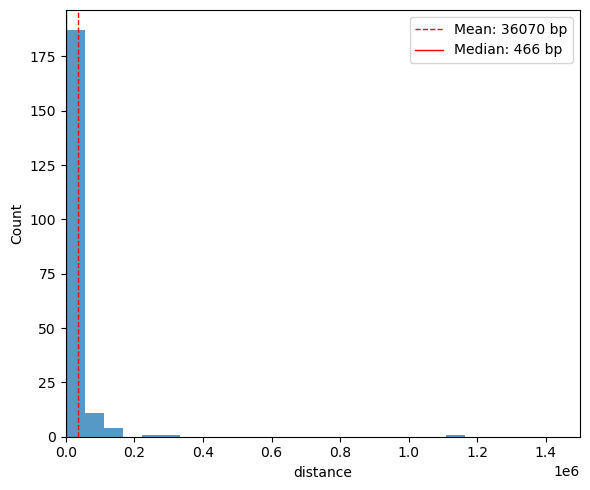

In [45]:
plt.figure(figsize=(6, 5))
sns.histplot(K562_fp_atac_gene_var_filtered['distance'], lw=0, bins=60)
np.mean(K562_fp_atac_gene_var_filtered['distance']), np.median(K562_fp_atac_gene_var_filtered['distance'])
plt.axvline(x=np.mean(K562_fp_atac_gene_var_filtered['distance']), color='r', lw=1, linestyle='--', label='Mean: {:.0f} bp'.format(np.mean(K562_fp_atac_gene_var_filtered['distance'])))
plt.axvline(x=np.median(K562_fp_atac_gene_var_filtered['distance']), color='r', lw=1, linestyle='-', label='Median: {:.0f} bp'.format(np.median(K562_fp_atac_gene_var_filtered['distance'])))
plt.xlim([-1, 1_500_000])
plt.legend()
plt.tight_layout()
plt.savefig('figure4_K562_fp_atac_gene_var_distance.pdf', transparent=True, dpi=500)

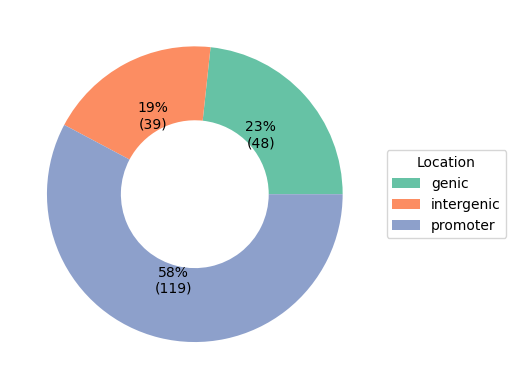

In [46]:
labels = ['genic', 'intergenic', 'promoter']
data = [48, 39, 119]
colors = sns.color_palette('Set2')

fig, ax = plt.subplots()

# Custom function to display both percentage and value
def autopct_format(pct, all_vals):
    absolute = int(round(pct/100. * sum(all_vals)))
    return f"{pct:.0f}%\n({absolute})"

wedges, texts, autotexts = ax.pie(
    data,
    # labels=labels,
    colors=colors,
    startangle=0,
    autopct=lambda pct: autopct_format(pct, data),
    wedgeprops=dict(width=0.5)
)
ax.legend(wedges, labels, title="Location", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.savefig("figure4_common_pep70_tfbs_cre_type.pdf", bbox_inches="tight", transparent=True)

In [41]:
gene_list = list(K562_fp_atac_gene_var_filtered[K562_fp_atac_gene_var_filtered['PIP']>=0.1]['TargetGene'].unique()) # list(K562_significant_fps_pivot[K562_significant_fps_pivot[trait] > 0]['TargetGene'].unique())
len(gene_list)

192

In [42]:
gene_list = list(K562_fp_atac_gene_var_filtered['TargetGene'].unique()) # list(K562_significant_fps_pivot[K562_significant_fps_pivot[trait] > 0]['TargetGene'].unique())
len(gene_list)

192

In [43]:
K562_fp_atac_gene_var_filtered[(K562_fp_atac_gene_var_filtered['PIP'] >= 0.1)&(K562_fp_atac_gene_var_filtered['PEP_cs'] >0.7)]

,name,class,TargetGene,distance,isSelfPromoter,hic_contact,activity_base,ABC.Score,ABC.Score.v1,Name_ATAC,Length_ATAC,Length_foodie,Name,rsID,foodie_id,PIP,PEP_cs
0,promoter|chr11:61890374-61892109,promoter,FADS3,303.5,True,0.062834,8.799785,1.000000,0.105354,promoter|chr11:61890374-61892109,1735,21,chr11:61891633-61891654,11:61659120_AC_A,chr11:61891633-61891654,0.104171,0.83000
1,promoter|chr19:19320271-19321742,promoter,SUGP1,494.5,True,0.082409,19.023542,1.000000,0.455851,promoter|chr19:19320271-19321742,1471,27,chr19:19321479-19321506,19:19432290_AG_A,chr19:19321479-19321506,0.323378,0.77250
2,promoter|chr3:171809418-171810874,promoter,PLD1,348.0,True,0.060085,11.228295,1.000000,0.367095,promoter|chr3:171809418-171810874,1456,30,chr3:171810484-171810514,3:171528283_GGA_G,chr3:171810484-171810514,0.320437,0.89875
3,promoter|chr5:73497822-73499110,promoter,BTF3,42.0,True,0.082541,26.157506,1.000000,0.612225,promoter|chr5:73497822-73499110,1288,13,chr5:73498410-73498423,5:72794248_CT_C,chr5:73498410-73498423,0.152295,0.70625
4,promoter|chr7:129952363-129953374,promoter,UBE2H,91.5,True,0.076927,7.931282,1.000000,0.191167,promoter|chr7:129952363-129953374,1011,30,chr7:129952692-129952722,7:129592540_CG_C,chr7:129952692-129952722,0.223285,0.72000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,promoter|chr1:25429686-25431642,promoter,TMEM57,193.0,True,0.087523,28.641906,1.000000,0.551154,promoter|chr1:25429686-25431642,1956,11,chr1:25430367-25430378,rs9438904,chr1:25430367-25430378,0.124720,0.72875
202,genic|chr6:20409252-20410137,genic,E2F3,7789.5,False,0.043243,14.374304,0.093345,0.107737,genic|chr6:20409252-20410137,885,16,chr6:20409542-20409558,rs9465733,chr6:20409542-20409558,0.334997,0.81125
203,promoter|chr13:41194057-41194905,promoter,KBTBD7,94.0,True,0.089085,7.451075,1.000000,0.385453,promoter|chr13:41194057-41194905,848,12,chr13:41194547-41194559,rs9525462,chr13:41194547-41194559,0.524607,0.79250
204,promoter|chr17:7483709-7485223,promoter,ZBTB4,217.0,True,0.065219,20.038358,1.000000,0.187209,promoter|chr17:7483709-7485223,1514,24,chr17:7484267-7484291,rs9901161,chr17:7484267-7484291,0.158075,0.70125


(41, 13)


/tmp/ipykernel_47621/3285386772.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


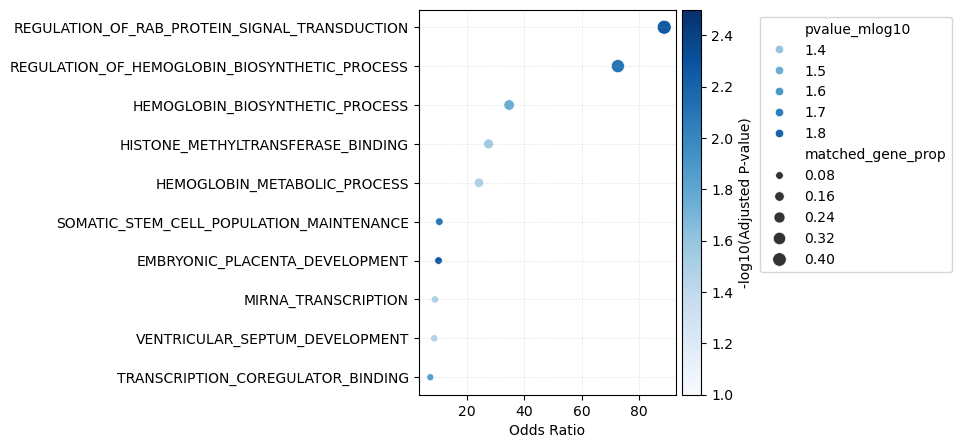

In [44]:
plt.figure(figsize=(4, 5))
# all_gene_list = # var2grn_dedup_short[var2grn_dedup_short['PIP'] > 0.05]['TargetGene'].unique().tolist()
# trait = 'MCH'|
gene_list = list(K562_fp_atac_gene_var_filtered['TargetGene'].unique()) # list(K562_significant_fps_pivot[K562_significant_fps_pivot[trait] > 0]['TargetGene'].unique())
enr = gp.enrichr(
            gene_list=gene_list,
            gene_sets='../FOODIE_20250407/GSEA_MSigDB/c5.go.v2025.1.Hs.symbols.gmt',  # see gp.get_library_name() for all
            organism='Human',
            cutoff=0.05,                # adjusted-p cutoff
        )
res2d_grp = enr.res2d
go_grp_sig = res2d_grp[res2d_grp['Adjusted P-value'] < 0.05].sort_values(by='Odds Ratio', ascending=False).reset_index(drop=True)
go_grp_sig['Term_split'] = go_grp_sig['Term'].str.split('_').apply(lambda x: '_'.join(x[1:7]) + '\n' + '_'.join(x[7:])  if len(x) > 7 else '_'.join(x[1:]))
go_grp_sig['matched_gene'] = go_grp_sig['Overlap'].str.split('/').str[0].astype(int)
go_grp_sig['total_gene'] = go_grp_sig['Overlap'].str.split('/').str[1].astype(int)
go_grp_sig['matched_gene_prop'] = go_grp_sig['matched_gene'] / go_grp_sig['total_gene']
go_grp_sig['pvalue_mlog10'] = -np.log10(go_grp_sig['Adjusted P-value'])
print(go_grp_sig.shape)
scatter = sns.scatterplot(
    data=go_grp_sig.head(10),
    x='Odds Ratio',
    y='Term_split',
    size='matched_gene_prop',
    hue='pvalue_mlog10',
    palette='Blues',
    sizes=(25, 100),
    hue_norm=(1, 2),
    legend='brief'  # Disable all legends
)
# Add size legend manually
# Add a heatmap-like colorbar for hue
norm = mpl.colors.Normalize(vmin=1, vmax=2.5)  # Same range as hue_norm
sm = mpl.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])  # Required for ScalarMappable
cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', pad=0.02)
cbar.set_label('-log10(Adjusted P-value)', rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1), ncol=1, frameon=True)
plt.grid(linewidth=0.5, linestyle='--', alpha=0.3)
plt.ylabel('')
plt.tight_layout()
plt.savefig('figure4_go_enrichment_erythroid.pdf', dpi=300, bbox_inches='tight')

In [45]:
K562_fp_atac_gene_var_dedup['TargetGene'].nunique()

7103

In [46]:
K562_fp_atac_gene_var_filtered = K562_fp_atac_gene_var_dedup[(K562_fp_atac_gene_var_dedup['ABC.Score'] > 0.015)&(K562_fp_atac_gene_var_dedup['PIP'] > 0.1)&(~K562_fp_atac_gene_var_dedup['PEP_cs'].isna())].reset_index(drop=True)
var_tfbs_alt_ref_effected_grn = var_tfbs_alt_ref_effected[['TF', 'rsID', 'TF_change', 'TF_K562_rna_tpm']].merge(K562_fp_atac_gene_var_filtered, on='rsID', how='outer') # .drop_duplicates()# .to_csv('./figure4_K562_erythroid_comvar_pip10_tfbs_changes_dedup.tsv', sep='\t', index=False)
var_tfbs_alt_ref_effected_grn_filtered = var_tfbs_alt_ref_effected_grn[(var_tfbs_alt_ref_effected_grn['PIP'] >= 0.)&(var_tfbs_alt_ref_effected_grn['TF_K562_rna_tpm']>0.5)].reset_index(drop=True)

In [64]:
var_tfbs_alt_ref_effected_grn_filtered[['rsID','TF', 'TF_change', 'TF_K562_rna_tpm', 'TargetGene', 'ABC.Score.v1', 'distance', 'foodie_id']].to_csv('./final_results_260126/varTFBridge_results/K562_comvar_TFBS_gene.csv', index=False)


In [50]:
var_tfbs_alt_ref_effected_grn['TargetGene'].nunique(), K562_fp_atac_gene_var_filtered['TargetGene'].nunique()

(192, 192)

In [59]:
# var_tfbs_alt_ref_effected_grn_expressed['rsID'].nunique()

In [60]:
var_tfbs_alt_ref_effected_grn_filtered['TF'].nunique()

195

In [145]:
# var_tfbs_alt_ref_effected_grn_filtered[var_tfbs_alt_ref_effected_grn_filtered['TF_change'] != 'Unchange']

In [61]:
# var_tfbs_alt_ref_effected_grn_filtered.groupby('TF')[['rsID']].count().sort_values(by='rsID', ascending=False).head(50)

In [64]:
var_tfbs_alt_ref_effected_grn_filtered['TargetGene'].nunique()

174

In [61]:
var_tfbs_alt_ref_effected_grn_filtered['TF'].nunique(), var_tfbs_alt_ref_effected_grn_filtered['rsID'].nunique()

(74, 38)

In [ ]:
var_tfbs_alt_ref_effected_grn_filtered.groupby('rsID')['TF'].nunique().describe()

count    185.000000
mean       3.583784
std        3.872248
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       28.000000
Name: TF, dtype: float64

In [126]:
tfbs_count = var_tfbs_alt_ref_effected_grn_filtered.groupby('TF')[['rsID']].count().sort_values(by='rsID', ascending=False).reset_index()

In [157]:
tfbs_count.head(20)

,TF,rsID
0,CTCF,37
1,ZNF460,22
2,PATZ1,21
3,SP1,16
4,KLF16,14
5,KLF10,14
6,KLF11,14
7,KLF9,13
8,ZBED4,13
9,ZNF93,13


In [138]:
tfbs_count[tfbs_count['TF'].str.startswith('SP')]['rsID'].sum()

66

In [152]:
tfbs_count[tfbs_count['TF'].str.startswith('KLF')]

,TF,rsID
4,KLF16,14
5,KLF10,14
6,KLF11,14
7,KLF9,13
20,KLF3,10
22,KLF15,9
23,KLF1,8
24,KLF6,8
39,KLF13,4


In [154]:
tfbs_count[tfbs_count['TF'].str.startswith('SP')]

,TF,rsID
3,SP1,16
15,SP3,12
16,SP2,12
17,SP4,12
19,SP8,11
56,SPI1,3


In [155]:
(94 + 66-2)/tfbs_count['rsID'].sum()

0.2383107088989442

In [141]:
tfbs_count[tfbs_count['TF'].str.startswith('GATA')]['rsID'].sum()

3

In [142]:
tfbs_count[tfbs_count['TF'].str.startswith('CTCF')]['rsID'].sum()

43

In [271]:
# var_tfbs_alt_ref_effected_grn_filtered.to_csv('./var2grn_20251126/K562_erythroid_var2grn_pip60_tfexpr05.tsv', sep='\t', index=False)

In [77]:
var_tfbs_alt_ref_effected_grn_filtered.columns

Index(['TF', 'rsID', 'TF_change', 'TF_K562_rna_tpm', 'name', 'class',
       'TargetGene', 'distance', 'isSelfPromoter', 'hic_contact',
       'activity_base', 'ABC.Score', 'ABC.Score.v1', 'Name_ATAC',
       'Length_ATAC', 'Length_foodie', 'Name', 'foodie_id', 'PIP', 'PEP_cs'],
      dtype='object')

In [54]:
sel_cols = ['rsID', 'name', 'class', 'name', 'class',
       'TargetGene', 'distance', 'isSelfPromoter', 'hic_contact',
       'activity_base', 'ABC.Score', 'ABC.Score.v1', 'Name', 'foodie_id', 'PIP']
var_info_all = []
for rs_id in tqdm(var_tfbs_alt_ref_effected_grn_filtered['rsID'].unique()):
    var_data = var_tfbs_alt_ref_effected_grn_filtered[var_tfbs_alt_ref_effected_grn_filtered['rsID'] == rs_id]
    var_info = var_data[sel_cols].drop_duplicates().reset_index(drop=True)
    # var_data = var_data['TF']
    # print('Variant:', rs_id)
    tf_change_stats = dict(var_data.groupby('TF_change')['TF'].unique())
    change_str = []
    for tfc in tf_change_stats.keys():
        change_str.append(tfc + ':' + ','.join(tf_change_stats[tfc]))
    change_str = '|'.join(change_str)
    var_info['TF_changes'] = change_str
    var_info_all.append(var_info)
var_info_all = pd.concat(var_info_all).sort_values(by='PIP', ascending=False).reset_index(drop=True)
var_info_all['Gene-TF'] = var_info_all['TargetGene'] + '-' + var_info_all['TF_changes']

100%|██████████| 185/185 [00:00<00:00, 360.18it/s]


In [55]:
TF_list = var_tfbs_alt_ref_effected['TF'].unique().tolist()
var_tfbs_alt_ref_effected_index = var_tfbs_alt_ref_effected.set_index(['rsID', 'TF'])
len(TF_list) 

343

In [56]:
change_idx_dict = {'Disrupt':-2, 'Decrease':-1, 'Increase':1, 'Create':2}
valid_TFs = []
for idx, row in var_info_all.iterrows():
    rsid = row['rsID']
    # print(rsid)
    rsid_fm_res = all_comvar_K562[all_comvar_K562['Name'] == rsid].reset_index(drop=True)
    for _, row in rsid_fm_res.iterrows():
        trait = row['trait']
        var_info_all.at[idx, trait] = row['PIP']
    for tf in TF_list:
        try:
            tf_change_res = var_tfbs_alt_ref_effected_index.loc[(rsid, tf)]
            var_info_all.at[idx, tf] = change_idx_dict[tf_change_res.loc['TF_change']]
            valid_TFs.append(tf)
        except:
            var_info_all.at[idx, tf] = 0
valid_TFs = list(set(valid_TFs))

/tmp/ipykernel_47621/4077081043.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  var_info_all.at[idx, tf] = 0
/tmp/ipykernel_47621/4077081043.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  var_info_all.at[idx, tf] = 0
/tmp/ipykernel_47621/4077081043.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fram

/cpl/home/linjc/miniconda3/envs/jc_py311/lib/python3.11/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


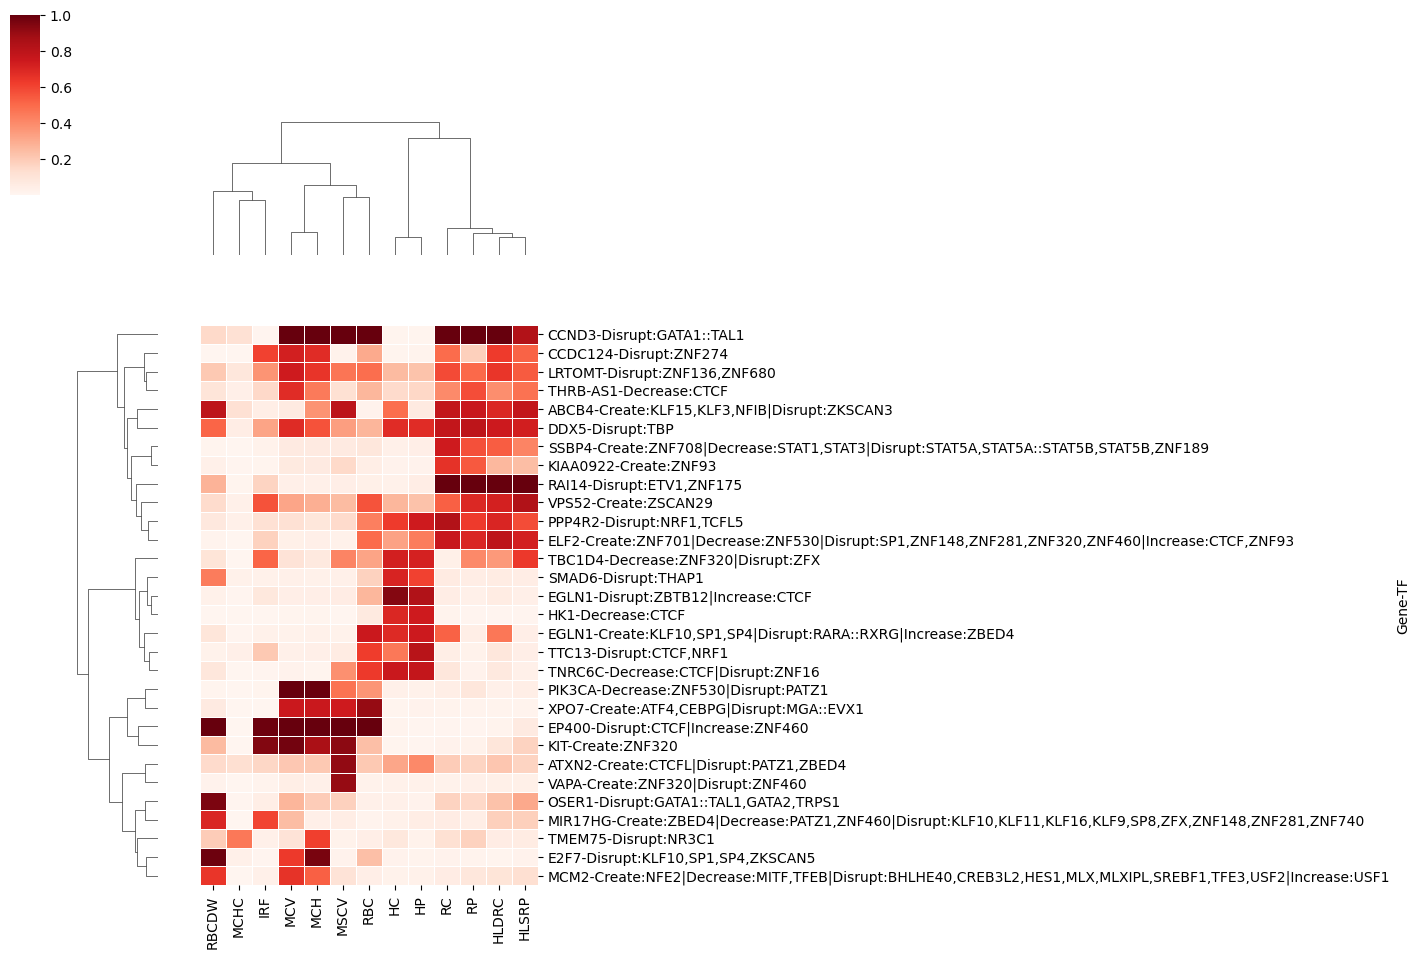

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

# 假设 df 是你的 DataFrame，包含数值列
# 1) 预处理：去掉非数值列与缺失（可换成填充）

# df_num = gene_tf_trait
# 2) 双向层次聚类并画热图
#   - z_score=0 表示按行做 z-score 标准化（常见于表达矩阵/评分矩阵）
#   - 也可用 standard_scale=1 按列标准化；二者不要同时用
# gene_tf_trait = gene_tf_trait.T
var_info_top30 = var_info_all.head(30)
gene_tf_trait = var_info_top30.set_index('Gene-TF')[all_comvar_K562['trait'].unique()]
cg = sns.clustermap(
    gene_tf_trait,
    method="ward",          # 链接方法：ward/average/complete/single
    metric="euclidean",     # 距离：euclidean/manhattan/correlation 等
    # z_score=0,              # 按行标准化；如不需要，设为 None
    linewidths=.5,
    cmap="Reds",
    figsize=(6, 10)
)
plt.show()

# 3) 取回聚类后的顺序（用于重排 DataFrame 或后续分析）
row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind
df_reordered = gene_tf_trait.iloc[row_order, col_order]

# 4) 获取行/列的簇标签（剪树得到 k 个簇）
from scipy.cluster.hierarchy import fcluster

k_rows = 4
k_cols = 3

row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind
df_reordered = gene_tf_trait.iloc[row_order, col_order]

# 4) 获取行/列的簇标签（剪树得到 k 个簇）
from scipy.cluster.hierarchy import fcluster

k_rows = 4
k_cols = 3

row_labels = fcluster(cg.dendrogram_row.linkage, t=k_rows, criterion='maxclust')
col_labels = fcluster(cg.dendrogram_col.linkage, t=k_cols, criterion='maxclust')

row_labels = pd.Series(row_labels, index=gene_tf_trait.index)      # 与原行索引对齐
col_labels = pd.Series(col_labels, index=gene_tf_trait.columns)    # 与原列名对齐

# 可把标签并回原表
df_with_row_cluster = gene_tf_trait.copy()
df_with_row_cluster['row_cluster'] = row_labels

In [66]:
all_comvar_K562_index = all_comvar_K562.set_index(['Name', 'trait'])
var_info = []
trait_list = all_comvar_K562['trait'].unique().tolist()
for idx, row in var_info_all.iterrows():
    for trait in trait_list: 
        effect = all_comvar_K562_index.loc[(row['rsID'], trait), 'A1Effect']
        var_freq = all_comvar_K562_index.loc[(row['rsID'], trait), 'A1Frq']
        pip = all_comvar_K562_index.loc[(row['rsID'], trait), 'PIP']
        var_info.append([row['rsID'], row['TF_changes'], row['TargetGene'], pip, row['ABC.Score.v1'], row['hic_contact'], row['activity_base'], effect, var_freq, trait])
var_info_df = pd.DataFrame(var_info, columns=['rsID', 'TF', 'TargetGene', 'PIP', 'ABC.Score', 'hic_contact', 'activity_base', 'effect', 'freq', 'trait'])
var_info_df['Gene-TF'] = var_info_df['TargetGene'] + '-' + var_info_df['TF']
for idx, row in var_info_df.iterrows():
    tf = row['TF']
    tf_name = ':'.join(tf.split(':')[1:])
    tf_change = tf.split(':')[0]
    var_info_df.at[idx, 'motif'] = tf_name
    var_info_df.at[idx, 'tf_change'] = tf_change

In [114]:
# ccnd3var

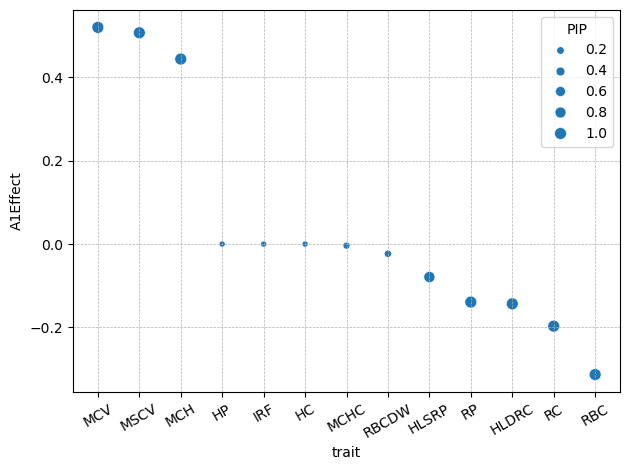

In [67]:
ccnd3var = all_comvar_K562[all_comvar_K562['Name'] == 'rs112233623'].reset_index(drop=True).sort_values(by='A1Effect', ascending=False)
sns.scatterplot(data=ccnd3var, x='trait', y='A1Effect', size='PIP') # all_comvar_K562[all_comvar_K562['Name'] == 'rs112233623']
plt.xticks(rotation=30)
plt.grid(linewidth=0.5, linestyle='--')
plt.tight_layout()


In [42]:
# var_info_all['rsID'].nunique()
# var_info_df.to_csv('./results_20251224/commonvar_tfbs_alt_ref_filtered.tsv', sep='\t', index=False)

In [68]:
alphascore_df = pd.read_csv('./K562_var2grn_pip70_alphagenome_score.tsv', sep='\t')
alphascore_H3k27ac = alphascore_df[(alphascore_df['biosample_name'] == 'K562')&(alphascore_df['histone_mark'] == 'H3K27ac')].reset_index(drop=True)# ['quantile_score']
for idx, row in alphascore_H3k27ac.iterrows():
    alpha_var_id = row['variant_id']
    alpha_var_format = alpha_var_id.replace(':', '_').replace('>', '_') + '_b38'
    alphascore_H3k27ac.at[idx, 'AlphaGenome_var_id'] = alpha_var_format

/tmp/ipykernel_47621/3509275423.py:1: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  alphascore_df = pd.read_csv('./K562_var2grn_pip70_alphagenome_score.tsv', sep='\t')


In [80]:
alphascore_H3k27ac.iloc[0]

variant_id                                              chr6:41957260:C>T
scored_interval                                  chr6:41432972-42481548:.
gene_id                                                               NaN
gene_name                                                             NaN
gene_type                                                             NaN
gene_strand                                                           NaN
junction_Start                                                        NaN
junction_End                                                          NaN
output_type                                                  CHIP_HISTONE
variant_scorer          CenterMaskScorer(requested_output=CHIP_HISTONE...
track_name                           EFO:0002067 Histone ChIP-seq H3K27ac
track_strand                                                            .
Assay title                                              Histone ChIP-seq
ontology_curie                        

In [90]:
alphascore_df[alphascore_df['variant_id'] == 'chr6:41957260:C>T'].to_csv('./final_results_260126/Supplementary Data 2.tsv', index=False, sep='\t')

In [73]:
!cp ./K562_var2grn_pip70_alphagenome_score.tsv ./final_results_260126/alphagenome_results/K562_credible_comvar_pip70.tsv

In [74]:
alphascore_tf =  alphascore_df[(alphascore_df['biosample_name'] == 'K562')].dropna(subset=['transcription_factor']).reset_index(drop=True)
for idx, row in alphascore_tf.iterrows():
    alpha_var_id = row['variant_id']
    alpha_var_format = alpha_var_id.replace(':', '_').replace('>', '_') + '_b38'
    alphascore_tf.at[idx, 'AlphaGenome_var_id'] = alpha_var_format

In [75]:
alphascore_tf['transcription_factor'].nunique()

269

In [77]:
alphascore_tf.to_csv('./final_results_260126/Supplementary Data 1.tsv', index=False, sep='\t')

In [ ]:
var_info_df[var_info_df['rsID'] == 'rs112233623'] # ['PIP']# .describe()

,rsID,TF,TargetGene,PIP,ABC.Score,hic_contact,activity_base,effect,freq,trait,Gene-TF,motif,tf_change
0,rs112233623,Disrupt:GATA1::TAL1,CCND3,1.000000,0.016542,0.019052,6.181912,0.520068,0.009718,MCV,CCND3-Disrupt:GATA1::TAL1,GATA1::TAL1,Disrupt
1,rs112233623,Disrupt:GATA1::TAL1,CCND3,0.121737,0.016542,0.019052,6.181912,-0.003621,0.009718,MCHC,CCND3-Disrupt:GATA1::TAL1,GATA1::TAL1,Disrupt
2,rs112233623,Disrupt:GATA1::TAL1,CCND3,1.000000,0.016542,0.019052,6.181912,0.443993,0.009718,MCH,CCND3-Disrupt:GATA1::TAL1,GATA1::TAL1,Disrupt
3,rs112233623,Disrupt:GATA1::TAL1,CCND3,1.000000,0.016542,0.019052,6.181912,-0.143146,0.009711,HLDRC,CCND3-Disrupt:GATA1::TAL1,GATA1::TAL1,Disrupt
4,rs112233623,Disrupt:GATA1::TAL1,CCND3,0.012213,0.016542,0.019052,6.181912,0.000043,0.009717,HC,CCND3-Disrupt:GATA1::TAL1,GATA1::TAL1,Disrupt
5,rs112233623,Disrupt:GATA1::TAL1,CCND3,1.000000,0.016542,0.019052,6.181912,0.507042,0.009711,MSCV,CCND3-Disrupt:GATA1::TAL1,GATA1::TAL1,Disrupt
6,rs112233623,Disrupt:GATA1::TAL1,CCND3,1.000000,0.016542,0.019052,6.181912,-0.312915,0.009717,RBC,CCND3-Disrupt:GATA1::TAL1,GATA1::TAL1,Disrupt
7,rs112233623,Disrupt:GATA1::TAL1,CCND3,0.005779,0.016542,0.019052,6.181912,0.000137,0.009711,IRF,CCND3-Disrupt:GATA1::TAL1,GATA1::TAL1,Disrupt
8,rs112233623,Disrupt:GATA1::TAL1,CCND3,0.146585,0.016542,0.019052,6.181912,-0.023142,0.009718,RBCDW,CCND3-Disrupt:GATA1::TAL1,GATA1::TAL1,Disrupt
9,rs112233623,Disrupt:GATA1::TAL1,CCND3,1.000000,0.016542,0.019052,6.181912,-0.139043,0.009711,RP,CCND3-Disrupt:GATA1::TAL1,GATA1::TAL1,Disrupt


In [82]:
alphascore_H3k27ac.iloc[0]

variant_id                                              chr6:41957260:C>T
scored_interval                                  chr6:41432972-42481548:.
gene_id                                                               NaN
gene_name                                                             NaN
gene_type                                                             NaN
gene_strand                                                           NaN
junction_Start                                                        NaN
junction_End                                                          NaN
output_type                                                  CHIP_HISTONE
variant_scorer          CenterMaskScorer(requested_output=CHIP_HISTONE...
track_name                           EFO:0002067 Histone ChIP-seq H3K27ac
track_strand                                                            .
Assay title                                              Histone ChIP-seq
ontology_curie                        

In [83]:
all_comvar_K562['variant_id'] = 'chr' + all_comvar_K562['CHROM'].astype(str) + ':' + all_comvar_K562['GENPOS'].astype(str) + ':' + all_comvar_K562['REF'] + '>' + all_comvar_K562['ALT']
alphascore_H3k27ac = alphascore_H3k27ac.merge(all_comvar_K562[['Name', 'variant_id']].rename(columns={'Name':'rsID'}).drop_duplicates(), on='variant_id')# .to_csv('all_comvar_K562.csv', index=False) 
alphascore_tf = alphascore_tf.merge(all_comvar_K562[['Name', 'variant_id']].rename(columns={'Name':'rsID'}).drop_duplicates(), on='variant_id')

In [84]:
# var_info_dedup = var_info_df.drop(columns=['effect', 'freq', 'trait', 'TF', 'Gene-TF', 'PIP']).drop_duplicates().reset_index(drop=True)
var_info_df = var_info_df.merge(alphascore_H3k27ac[[ 'rsID', 'histone_mark', 'raw_score', 'quantile_score']], on='rsID').reset_index(drop=True)
# var_tf_info_df = var_info_df.merge(alphascore_tf[['rsID', 'transcription_factor', 'raw_score', 'quantile_score']], on='rsID',).reset_index(drop=True)
alphascore_top30_dedup = pd.read_csv('./results_20251224/commonvar_tfbs_alt_ref_filtered_alphagenome_score.tsv', sep='\t')

In [87]:
alphascore_H3k27ac[alphascore_H3k27ac['rsID'] == 'rs112233623']

,variant_id,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,variant_scorer,...,ontology_curie,biosample_name,biosample_type,transcription_factor,histone_mark,gtex_tissue,raw_score,quantile_score,AlphaGenome_var_id,rsID
0,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_HISTONE,CenterMaskScorer(requested_output=CHIP_HISTONE...,...,EFO:0002067,K562,cell_line,NaN,H3K27ac,NaN,-0.345359,-0.99884,chr6_41957260_C_T_b38,rs112233623


In [ ]:
alphascore_top30_dedup[alphascore_top30_dedup['rsID'] == 'rs112233623'].sort_values(by='quantile_score', ascending=False).tail(30)

,rsID,variant_id,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,...,ontology_curie,biosample_name,biosample_type,transcription_factor,histone_mark,gtex_tissue,raw_score,quantile_score,AlphaGenome_var_id,tfbs_change
2363,rs112233623,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,EFO:0002067,K562,cell_line,TBL1XR1,NaN,NaN,-0.593256,-0.998990,chr6_41957260_C_T_b38,Uncahnge
2259,rs112233623,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,EFO:0002067,K562,cell_line,KDM1A,NaN,NaN,-0.478047,-0.999036,chr6_41957260_C_T_b38,Uncahnge
2211,rs112233623,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,EFO:0002067,K562,cell_line,EP300,NaN,NaN,-0.802813,-0.999036,chr6_41957260_C_T_b38,Uncahnge
2376,rs112233623,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,EFO:0002067,K562,cell_line,TRIM24,NaN,NaN,-0.500215,-0.999036,chr6_41957260_C_T_b38,Uncahnge
2276,rs112233623,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,EFO:0002067,K562,cell_line,MEIS2,NaN,NaN,-0.553117,-0.999058,chr6_41957260_C_T_b38,Uncahnge
2146,rs112233623,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,EFO:0002067,K562,cell_line,ARID1B,NaN,NaN,-0.691365,-0.999100,chr6_41957260_C_T_b38,Uncahnge
2288,rs112233623,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,EFO:0002067,K562,cell_line,MYNN,NaN,NaN,-0.430760,-0.999160,chr6_41957260_C_T_b38,Uncahnge
2362,rs112233623,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,EFO:0002067,K562,cell_line,TARDBP,NaN,NaN,-0.335842,-0.999179,chr6_41957260_C_T_b38,Uncahnge
2307,rs112233623,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,EFO:0002067,K562,cell_line,NR2F2,NaN,NaN,-0.582745,-0.999216,chr6_41957260_C_T_b38,Uncahnge
2296,rs112233623,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,...,EFO:0002067,K562,cell_line,NFIC,NaN,NaN,-0.568821,-0.999216,chr6_41957260_C_T_b38,Uncahnge


In [54]:
alphascore_tf

,variant_id,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,variant_scorer,...,ontology_curie,biosample_name,biosample_type,transcription_factor,histone_mark,gtex_tissue,raw_score,quantile_score,AlphaGenome_var_id,rsID
0,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,ADNP,NaN,NaN,-0.227806,-0.993474,chr6_41957260_C_T_b38,rs112233623
1,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,AFF1,NaN,NaN,-0.226310,-0.996574,chr6_41957260_C_T_b38,rs112233623
2,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,AFF4,NaN,NaN,-0.202412,-0.996413,chr6_41957260_C_T_b38,rs112233623
3,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,AGO1,NaN,NaN,0.023587,0.599367,chr6_41957260_C_T_b38,rs112233623
4,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,ARID1B,NaN,NaN,-0.691365,-0.999100,chr6_41957260_C_T_b38,rs112233623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9175,chr13:75481466:G>A,chr13:74957178-76005754:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,ZNF740,NaN,NaN,-0.020411,-0.871233,chr13_75481466_G_A_b38,rs77685055
9176,chr13:75481466:G>A,chr13:74957178-76005754:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,ZNF766,NaN,NaN,-0.047430,-0.933411,chr13_75481466_G_A_b38,rs77685055
9177,chr13:75481466:G>A,chr13:74957178-76005754:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,ZNF778,NaN,NaN,0.062496,0.961175,chr13_75481466_G_A_b38,rs77685055
9178,chr13:75481466:G>A,chr13:74957178-76005754:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,ZNF83,NaN,NaN,-0.043687,-0.943060,chr13_75481466_G_A_b38,rs77685055


In [ ]:
# var_info_df[var_info_df['rsID'] == 'rs11735662']
# alphascore_top30_dedup = alphascore_top30_dedup

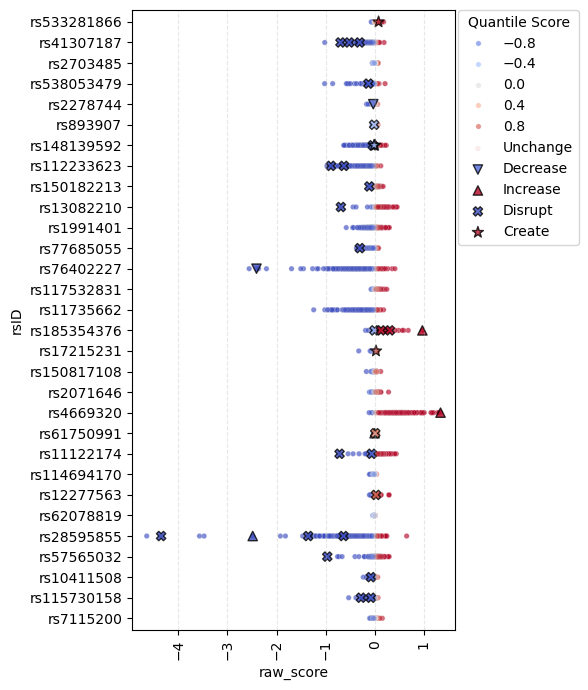

In [58]:
plt.figure(figsize=(6, 7)) 
norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0) 
unchanged_tfbs = alphascore_top30_dedup[alphascore_top30_dedup['tfbs_change'] == 'Uncahnge'].reset_index(drop=True)
decreased_tfbs = alphascore_top30_dedup[alphascore_top30_dedup['tfbs_change'] == 'Decrease'].reset_index(drop=True)
increased_tfbs = alphascore_top30_dedup[alphascore_top30_dedup['tfbs_change'] == 'Increase'].reset_index(drop=True)
disrupted_tfbs = alphascore_top30_dedup[alphascore_top30_dedup['tfbs_change'] == 'Disrupt'].reset_index(drop=True)
create_tfbs = alphascore_top30_dedup[alphascore_top30_dedup['tfbs_change'] == 'Create'].reset_index(drop=True)
ax = sns.scatterplot(data=alphascore_top30_dedup, y='rsID', x='raw_score',
            hue='quantile_score', palette='coolwarm', hue_norm=norm, s=15, alpha=0.6)
sns.scatterplot(data=unchanged_tfbs, y='rsID', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='o', s=15, ax=ax, alpha=0.1, legend=False, label='Unchange')
sns.scatterplot(data=decreased_tfbs, y='rsID', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='v', s=45, ax=ax, alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Decrease')
sns.scatterplot(data=increased_tfbs, y='rsID', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='^', s=45, ax=ax, alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Increase')
sns.scatterplot(data=disrupted_tfbs, y='rsID', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='X', s=45, ax=ax, alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Disrupt')
sns.scatterplot(data=create_tfbs, y='rsID', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='*', s=70, ax=ax, alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Create')
# -ax = sns.scatterplot(data=alphascore_top30_dedup, y='rsID', x='raw_score', hue='quantile_score', palette='vlag', s=15, alpha=0.5, hue_norm=norm) # vlag
ax.margins(y=0.02)
plt.xticks(rotation=90)
plt.grid(axis='x', linestyle='--', alpha=0.3)
# move legend outside
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title='Quantile Score')
plt.tight_layout()

In [91]:
alphascore_top30_dedup_order = alphascore_top30_dedup.set_index('rsID').loc[list(var_info_df['rsID'].drop_duplicates())[::-1]].reset_index()

In [72]:
alphascore_top30_dedup[(abs(alphascore_top30_dedup['quantile_score']) > 0.8)&(alphascore_top30_dedup['tfbs_change'] != 'Uncahnge')]['transcription_factor'].unique()

array(['SP1', 'GATA1', 'GATA2', 'TAL1', 'STAT5A', 'CTCF', 'MGA', 'NRF1',
       'ZFX', 'ZNF281', 'ETV5', 'REST', 'TFAP4', 'ZNF274', 'ETV1',
       'ZNF175'], dtype=object)

In [1]:
from matplotlib.colors import ListedColormap
var_info_df['effect_direction'] = var_info_df['effect']>0 
# Define the desired order for the 'trait' column
desired_trait_order = df_reordered.columns  # Replace with your desired order if different
var_info_df = var_info_df.set_index('Gene-TF').loc[df_reordered.index].reset_index()
# Set the 'trait' column as a categorical variable with the desired order
var_info_df['trait'] = pd.Categorical(var_info_df['trait'], categories=desired_trait_order, ordered=True)

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 10), gridspec_kw={'width_ratios': [0.7, 0.7, 6, 4.5]})  # Adjust height ratios

sns.heatmap(
    data=var_info_df.drop_duplicates(subset=['rsID']).set_index('Gene-TF').loc[df_reordered.index[::-1]][['rsID', 'raw_score']].set_index('rsID'),  # Replace with your ABC.core DataFrame
    cmap='coolwarm',
    cbar=True,
    # cbar_kws={'label': 'alphagenome'},
    ax=axes[0],  # Use the second subplot
    xticklabels=True,
    yticklabels=True,
    linewidths=0.5,
)
# add cbar outside
# axes[0].set_xlabel('alphagenome H3K27ac score')
axes[0].set_ylabel('')
axes[0].tick_params(axis='x', labelrotation=90)

sns.heatmap(
    data=var_info_df.drop_duplicates(subset=['rsID']).set_index('Gene-TF').loc[df_reordered.index[::-1]][['rsID', 'ABC.Score']].set_index('rsID'),  # Replace with your ABC.core DataFrame
    cmap='Blues',
    cbar=True,
    # cbar_kws={'label': 'ABC Score'},
    ax=axes[1],  # Use the second subplot
    xticklabels=True,
    yticklabels=True,
    linewidths=0.5,
)
axes[1].set_ylabel('')
axes[1].set_yticks([])
axes[1].tick_params(axis='x', labelrotation=90)
# axes[0].legend(
#     bbox_to_anchor=(0.9, 1.08),  # Center the legend horizontally and move it above the plot
#     # loc='center',  # Align the legend to the center
#     # borderaxespad=0.,
#     # title='PIP'  # Add a title to the legend
# )
# Top subplot: Scatter plot
marker_map = {False: 'v', True: '^'}
sns.scatterplot(
    data=var_info_df,
    x='trait',
    y='Gene-TF',
    hue='PIP',
    size='PIP',
    alpha=0.7,
    sizes=(10, 150),
    style='effect_direction',
    markers=marker_map,
    linewidth=0.6,
    hue_norm=(0, 1),
    edgecolors='black',
    palette='Reds',
    ax=axes[2]  # Use the first subplot
)
yticks = axes[2].get_yticks()
yticklabels = [t.get_text() for t in axes[1].get_yticklabels()]

# hide left labels
# Add a secondary x-axis at the top
ax_right = axes[2].secondary_yaxis('right')
ax_right.set_yticks(axes[2].get_yticks())
ax_right.set_yticklabels('')
# ax_right.set_yticklabels(axes[2].get_yticklabels())
# # ax_right.set_ylabel('Transcription factor')  # Label for the top x-axis
axes[2].set_yticklabels(var_info_df.drop_duplicates(subset=['rsID', 'hic_contact'])['TargetGene'])
axes[2].set_ylabel('')
axes[2].set_xlabel('')

# Optional: move them a bit right by adding padding
# ax_top.tick_params(axis='x', pad=10)   # increase pad to push labels further away
axes[2].legend(
    bbox_to_anchor=(0.9, 1.1),  # Center the legend horizontally and move it above the plot
    loc='center',  # Align the legend to the center
    borderaxespad=0.,
    # title='PIP'  # Add a title to the legend
)
axes[2].set_ylim(-0.5, 29.5)
axes[2].tick_params(axis='x', labelrotation=90)
# share y axis
norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0) 
unchanged_tfbs = alphascore_top30_dedup_order[alphascore_top30_dedup_order['tfbs_change'] == 'Uncahnge'].reset_index(drop=True)
decreased_tfbs = alphascore_top30_dedup_order[alphascore_top30_dedup_order['tfbs_change'] == 'Decrease'].reset_index(drop=True)
increased_tfbs = alphascore_top30_dedup_order[alphascore_top30_dedup_order['tfbs_change'] == 'Increase'].reset_index(drop=True)
disrupted_tfbs = alphascore_top30_dedup_order[alphascore_top30_dedup_order['tfbs_change'] == 'Disrupt'].reset_index(drop=True)
create_tfbs = alphascore_top30_dedup_order[alphascore_top30_dedup_order['tfbs_change'] == 'Create'].reset_index(drop=True)
sns.scatterplot(data=alphascore_top30_dedup_order, y='rsID', x='raw_score',
            hue='quantile_score', palette='coolwarm', hue_norm=norm, s=15, alpha=0.6, ax=axes[3])
sns.scatterplot(data=unchanged_tfbs, y='rsID', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='o', s=15, ax=axes[3], alpha=0.1, legend=False, label='Unchange')
sns.scatterplot(data=decreased_tfbs, y='rsID', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='v', s=45, ax=axes[3], alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Decrease')
sns.scatterplot(data=increased_tfbs, y='rsID', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='^', s=45, ax=axes[3], alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Increase')
sns.scatterplot(data=disrupted_tfbs, y='rsID', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='X', s=45, ax=axes[3], alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Disrupt')
sns.scatterplot(data=create_tfbs, y='rsID', x='raw_score',  hue='quantile_score',  palette='coolwarm', hue_norm=norm, marker='*', s=70, ax=axes[3], alpha=0.8, linewidth=1, edgecolors='black', legend=False, label='Create')
# set grid
axes[3].grid(axis='x', linestyle='--', alpha=0.3)
# -ax = sns.scatterplot(data=alphascore_top30_dedup, y='rsID', x='raw_score', hue='quantile_score', palette='vlag', s=15, alpha=0.5, hue_norm=norm) # vlag
axes[3].margins(y=0.02)
# plt.xticks(rotation=90)
# plt.grid(axis='x', linestyle='--', alpha=0.3)
# move legend outside
axes[3].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title='Quantile Score')
# plt.tight_layout()

# Adjust layout
plt.tight_layout()
plt.savefig('figure4_comvar2grn_v2.pdf', transparent=True, format='pdf', bbox_inches='tight')

NameError: name 'var_info_df' is not defined

In [90]:
alphascore_top30_dedup_order

,variant_id,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,variant_scorer,...,ontology_curie,biosample_name,biosample_type,transcription_factor,histone_mark,gtex_tissue,raw_score,quantile_score,AlphaGenome_var_id,tfbs_change
rsID,,,,,,,,,,,,,,,,,,,,,
rs2703485,chr4:54571325:T>C,chr4:54047037-55095613:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,ADNP,NaN,NaN,-0.012568,-0.674555,chr4_54571325_T_C_b38,Uncahnge
rs2703485,chr4:54571325:T>C,chr4:54047037-55095613:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,AFF1,NaN,NaN,-0.013175,-0.668219,chr4_54571325_T_C_b38,Uncahnge
rs2703485,chr4:54571325:T>C,chr4:54047037-55095613:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,AFF4,NaN,NaN,-0.008602,-0.553174,chr4_54571325_T_C_b38,Uncahnge
rs2703485,chr4:54571325:T>C,chr4:54047037-55095613:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,AGO1,NaN,NaN,0.021576,0.553174,chr4_54571325_T_C_b38,Uncahnge
rs2703485,chr4:54571325:T>C,chr4:54047037-55095613:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,ARID1B,NaN,NaN,-0.025755,-0.807218,chr4_54571325_T_C_b38,Uncahnge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs112233623,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,ZNF740,NaN,NaN,-0.095675,-0.986702,chr6_41957260_C_T_b38,Uncahnge
rs112233623,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,ZNF766,NaN,NaN,-0.348451,-0.998118,chr6_41957260_C_T_b38,Uncahnge
rs112233623,chr6:41957260:C>T,chr6:41432972-42481548:.,NaN,NaN,NaN,NaN,NaN,NaN,CHIP_TF,"CenterMaskScorer(requested_output=CHIP_TF, wid...",...,EFO:0002067,K562,cell_line,ZNF778,NaN,NaN,-0.031741,-0.947949,chr6_41957260_C_T_b38,Uncahnge


In [ ]:
# yticklabels

In [57]:
# var_info_df 

In [105]:
# variant effect visualization